# Projet 6 : Classification des biens de consommation
## Partie 1 : Etude de faisabilité à partir du texte

### Objectifs

- [Importer les modules nécéssaires](#Importer-les-modules-nécéssaires)
- [Télécharger des données](#Télécharger-des-données)
- [Traîtement des catégories](#Traîtement-des-catégories)
- [Exploration-de-données](#Exploration-de-données)
- [Découpage du jeu de données : X_train et X_test](#Découpage-du-jeu-de-données-:-X_train-et-X_test)
- [Néttoyage de données textuelles](#Néttoyage-de-données-textuelles)
   * [L'ensemble du corpus](#L'ensemble-du-corpus)
   * [Par catégories](#Par-catégories)
- [TF-IDF](#TF-IDF)
- [Réduction de dimension (LDA/NMF)](#Réduction-de-dimension-(LDA/NMF))
- [Classifieurs supervisés sur données textuelles](#Classifieurs-supervisés-sur-données-textuelles)
   * [Classifieur Multinomial Baive Bayes](#Classifieur-Multinomial-Baive-Bayes)
   * [Classifier SVC](#Classifier-SVC)
   * [Classifier SVC sur jeu de données post LDA](#Classifier-SVC-sur-jeu-de-données-post-LDA)
   * [Classifier Logistic Regression](#Classifier-Logistic-Regression)
- [Classifieurs non supervisés sur données textuelles](#Classifieurs-non-supervisés-sur-données-textuelles)
- [Sentence Embedding - Présentation générale](#Sentence-Embedding---Présentation-générale)
   * [Nettoyage du texte](#Nettoyage-du-texte)
   * [Préparation commune des traitements](#Préparation-commune-des-traitements)
   * [Fonctions communes](#Fonctions-communes) 
   * [Bag of word - Tf-idf](#Bag-of-word---Tf-idf)   
      * [Préparation sentences](#Préparation-sentences)
      * [Exécution des modèles](#Exécution-des-modèles)
      * [Graphiques](#Graphiques)
   * [Word2Vec](#Word2Vec)
      * [Création du modèle Word2Vec](#Création-du-modèle-Word2Vec)  
      * [Création de la matrice d'embedding](#Création-de-la-matrice-d'embedding)      
      * [Création du modèle d'embedding](#Création-du-modèle-d'embedding)      
      * [Exécution du modèle](#Exécution-du-modèle)      
      * [Graphiques](#Graphiques)     
   * [BERT](#BERT)   
      * [Fonctions communes](#Fonctions-communes-2) 
      * [BERT HuggingFace](#BERT-HuggingFace)      
          * [Création du modèle](#Création-du-modèle)
          * [Entraînement du modèle](#Entraînement-du-modèle)
          * [Graphiques-2](#Graphiques-2)
      * [BERT hub Tensorflow](#BERT-hub-Tensorflow)      
          * [Création du modèle](#Création-du-modèle-2)
          * [Entraînement du modèle](#Entraînement-du-modèle-2)
          * [Graphiques](#Graphiques-3)
   * [USE - Universal Sentence Encoder](#USE---Universal-Sentence-Encoder)
      * [Création du modèle](#Création-du-modèle-3)      
      * [Entraînement du modèle](#Entraînement-du-modèle-3)      
      * [Graphiques](#Graphiques-4)


### Importer les modules nécéssaires

In [1]:
import os, sys, time, random

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [3]:
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn import manifold, decomposition

from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display 

In [4]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import gensim
import pickle

# Bert
import transformers

os.environ["TF_KERAS"]='1'

import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

2023-05-21 21:19:17.114771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 21:19:17.710783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


2023-05-21 21:19:18.398409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 21:19:18.471485: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 21:19:18.471675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords
from string import punctuation 

#from nltk import word_tokenize          
#import spacy

from wordcloud import WordCloud
from PIL import Image

import plotly as px

from pandarallel import pandarallel

In [8]:
#from IPython.display import display_html
import fontionsUtiles_texte as fctUtiles

version pandas :  1.5.3


In [9]:
#!pip install textblob
#!pip install pydot
#!pip install graphviz

In [10]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt  

In [11]:
pd.set_option("display.max_colwidth", 100)

In [12]:
#sns.set()
# pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=7,) #verbose=1

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Fonctions utiles

### Télécharger des données

In [13]:
df_1 = pd.read_csv('./data/data_1/flipkart_com-ecommerce_sample_1050.csv')
#https://www.kaggle.com/datasets/atharvjairath/flipkart-ecommerce-dataset?resource=download
#df_2 = pd.read_csv('./data/data_1/flipkart_com-ecommerce_sample.csv')

In [14]:
print(df_1.shape,df_2.shape)

(1050, 15) (20002, 15)


In [15]:
df_1.sample(3)

uniq_id            crawl_timestamp  \
242  799ddb97164ff2d5d53bb8b27b8c355f  2015-12-01 12:40:44 +0000   
125  7241df1acae1fac892c692097ea3fb98  2015-12-01 12:40:44 +0000   
796  170fdf050c7a1f8d30ef5a98c4216f9c  2015-12-12 11:46:53 +0000   

                                                                                             product_url  \
242  http://www.flipkart.com/indian-art-villa-2-3-x-6-9-handmade-high-quality-stainless-steel-copper-...   
125  http://www.flipkart.com/sally-hansen-la-cross-5-pcs-festival-grooming-kit/p/itmdszqssfsmkr3q?pid...   
796           http://www.flipkart.com/r-s-d-g16-analog-watch-men/p/itmeaffaybnvrgv6?pid=WATEAFFAYYAHCDQF   

                                                                                            product_name  \
242  Indian Art Villa 2.3" X 6.9" X 2.3" Handmade High Quality Stainless Steel Copper Dish Serving In...   
125                                                    Sally Hansen La Cross 5 Pcs Festival Grooming Kit   
796                                                                    R.S D&G16 Analog Watch  - For Men   

                                                                                   product_category_tree  \
242  ["Kitchen & Dining >> Cookware >> Pots & Pans >> Woks & Kadhais >> Indian Art Villa Woks & Kadha...   
125  ["Beauty and Personal Care >> Body and Skin Care >> Hand Care >> Manicure and Kits >> Sally Hans...   
796                                                    ["Watches >> Wrist Watches >> R.S Wrist Watches"]   

                  pid  retail_price  discounted_price  \
242  PTPEATF8HNUX8SGY        1885.0             750.0   
125  MNKDSZQR3NAMFTDQ         280.0             212.0   
796  WATEAFFAYYAHCDQF        1199.0             241.0   

                                    image  is_FK_Advantage_product  \
242  799ddb97164ff2d5d53bb8b27b8c355f.jpg                    False   
125  7241df1acae1fac892c692097ea3fb98.jpg                    False   
796  170fdf050c7a1f8d30ef5a98c4216f9c.jpg                    False   

                                                                                             description  \
242  Buy Indian Art Villa 2.3" X 6.9" X 2.3" Handmade High Quality Stainless Steel Copper Dish Servin...   
125  Flipkart.com: Buy Sally Hansen La Cross 5 Pcs Festival Grooming Kit for Rs. 0.0 from Flipkart.co...   
796  R.S D&G16 Analog Watch  - For Men - Buy R.S D&G16 Analog Watch  - For Men  D&G16 Online at Rs.24...   

          product_rating       overall_rating             brand  \
242  No rating available  No rating available  Indian Art Villa   
125  No rating available  No rating available               NaN   
796  No rating available  No rating available               NaN   

                                                                                  product_specifications  
242  {"product_specification"=>[{"key"=>"Pan Type", "value"=>"Curry"}, {"key"=>"Brand", "value"=>"Ind...  
125  {"product_specification"=>[{"key"=>"Set Contents", "value"=>"Manicure Kit"}, {"key"=>"Ideal For"...  
796  {"product_specification"=>[{"key"=>"Chronograph", "value"=>"No"}, {"key"=>"Date Display", "value...

In [16]:
import fontionsUtiles_texte as fctUtiles

In [17]:
# Aperçu des données
df1 = fctUtiles.formats(df_1, '')
df2 = fctUtiles.vars_types(df_1)
df3 = fctUtiles.colunmLigneDuplicated(df_1,'')
dfs = {'Flipkart': df1, 'Types de variables': df2, 'Colonnes/Lignes dupliquées':df3}
fctUtiles.display_dfs(dfs, justify='flex-start')

version pandas :  1.5.3


Flipkart 

 
 
 
 
 Nbre de lignes 
 Nbre de variables 
 
 
 
 
 
 1050 
 15 
 
 
 
 Types de variables 

 
 
 
 
 Objet 
 Float 
 Int 
 Bool 
 
 
 
 
 
 12 
 2 
 0 
 1 
 
 
 
 Colonnes/Lignes dupliquées 

 
 
 
 
 Colonnes dupliquées 
 Lignes dupliquées 
 
 
 
 
 
 0 
 0

In [18]:
df_1.isnull().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

<Axes: >

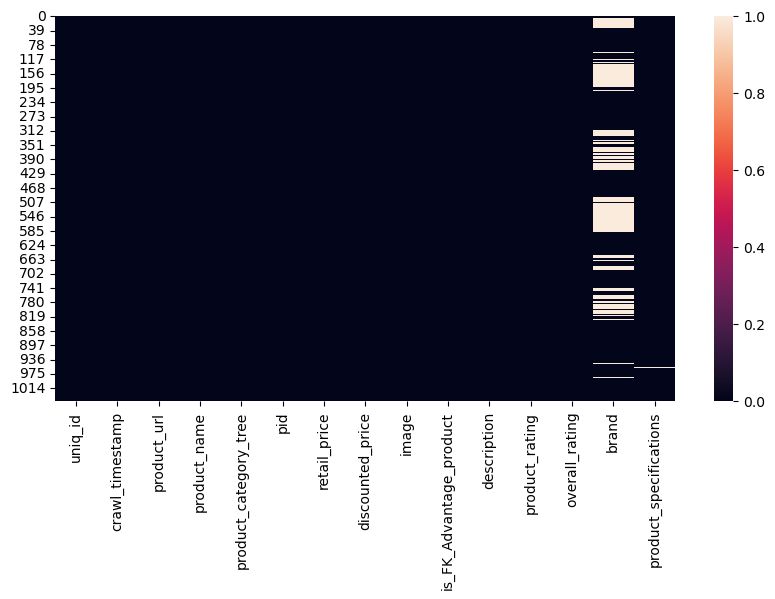

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(df_1.isna(), cbar=True)

In [20]:
df_1['product_category_tree'].nunique()

642

In [21]:
df_1['product_category_tree'].head(5)

0    ["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstrac...
1    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cot...
2    ["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotto...
3    ["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL ...
4    ["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Flo...
Name: product_category_tree, dtype: object

In [22]:
df_1['product_category_tree'][1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [23]:
df_1['product_category_tree'][1].split('["')[1].split('"]')[0].split(' >> ')

['Baby Care',
 'Baby Bath & Skin',
 'Baby Bath Towels',
 'Sathiyas Baby Bath Towels',
 'Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...']

- Nous allons décliner la valeur de la variable **product_category_tree** en 3 niveaux : cat_lvl_1, cat_lvl_1 et cat_lvl_1

### Traîtement des catégories

In [24]:
#Traitement des catégories
def split_categories(category, level):
    '''Fonction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def detail_categories(dataframe):
    dataframe['cat_lvl_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_lvl_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_lvl_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [25]:
df_1 = detail_categories(df_1)

In [26]:
df_1[['cat_lvl_1','cat_lvl_2','cat_lvl_3']].sample(5)

cat_lvl_1    cat_lvl_2                   cat_lvl_3
247            Kitchen & Dining     Cookware                 Pots & Pans
898    Beauty and Personal Care  Health Care     Health Care Accessories
221  Home Decor & Festive Needs   Showpieces  S C Handicrafts Showpieces
909                   Baby Care  Infant Wear         Baby Girls' Clothes
314    Beauty and Personal Care   Fragrances                  Deodorants

In [27]:
df_1.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

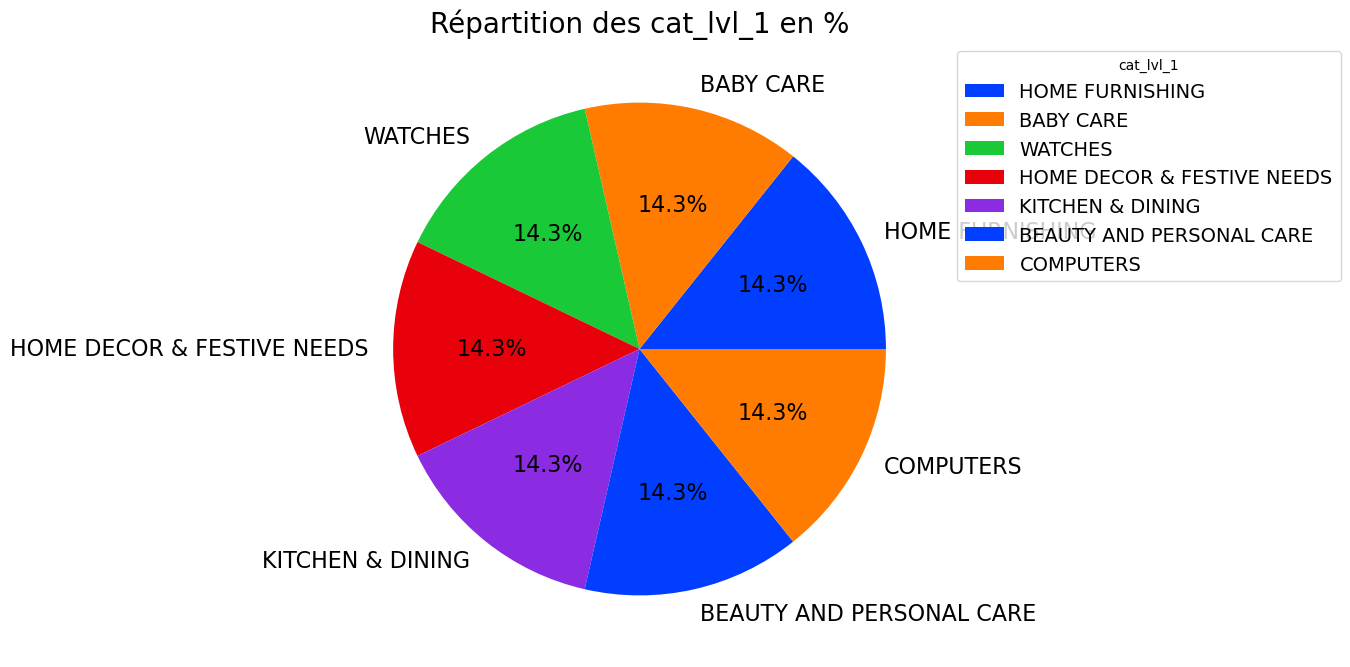

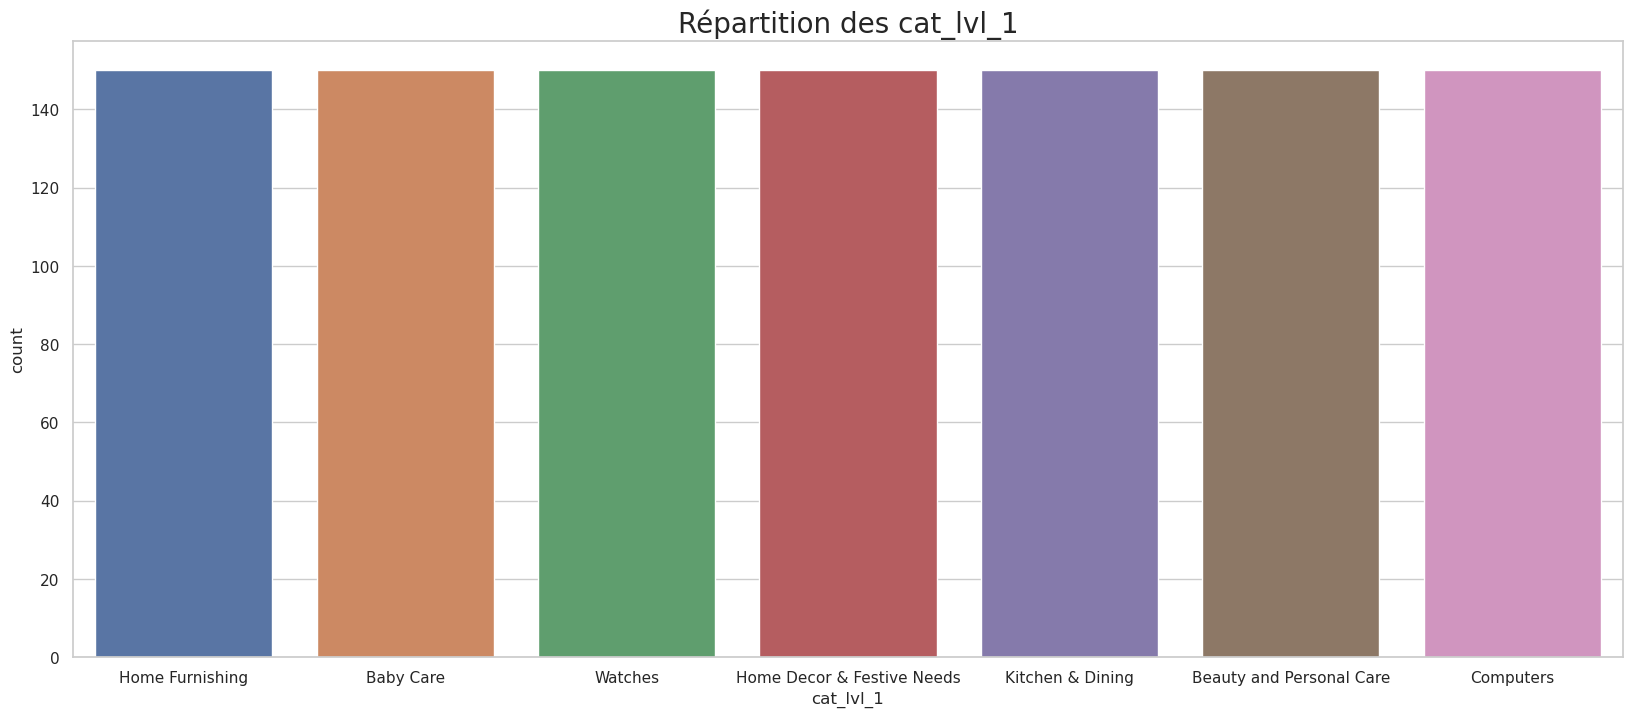

In [28]:
fctUtiles.dessinerCamembert(df_1, 'cat_lvl_1')

In [29]:
cat_groubed = pd.DataFrame((df_1.groupby(['cat_lvl_1','cat_lvl_2'])['cat_lvl_2'].count()))

In [30]:
cat_groubed

cat_lvl_2
cat_lvl_1        cat_lvl_2                            
Baby Care        Baby & Kids Gifts                  15
                 Baby Bath & Skin                   14
                 Baby Bedding                       15
                 Baby Grooming                       4
                 Diapering & Potty Training          7
...                                                ...
Kitchen & Dining Lighting                            7
                 Pressure Cookers & Pans             1
                 Tableware & Cutlery                 3
Watches          Clocks                              1
                 Wrist Watches                     149

[62 rows x 1 columns]

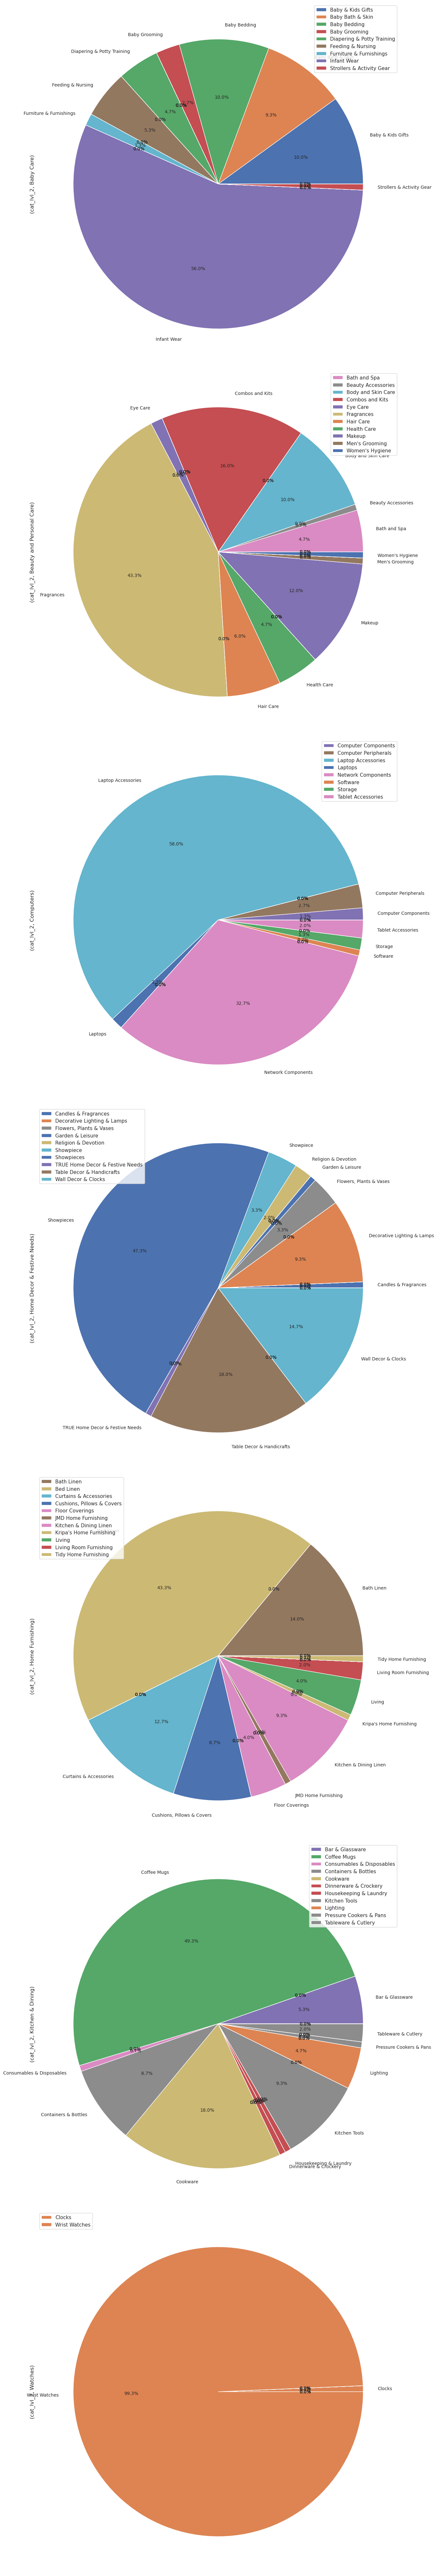

In [31]:
ax = cat_groubed.unstack(0).plot(kind='pie', textprops={'size': 'smaller'},
                          subplots=True, rot=0, figsize=(15, 80), layout=(7, 1),legend=True, autopct='%1.1f%%')

ax = plt.gca()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
ax.legend(loc="upper left")
plt.tight_layout()

In [32]:
cat_groubed.unstack()

cat_lvl_2                                \
cat_lvl_2                  Baby & Kids Gifts Baby Bath & Skin Baby Bedding   
cat_lvl_1                                                                    
Baby Care                               15.0             14.0         15.0   
Beauty and Personal Care                 NaN              NaN          NaN   
Computers                                NaN              NaN          NaN   
Home Decor & Festive Needs               NaN              NaN          NaN   
Home Furnishing                          NaN              NaN          NaN   
Kitchen & Dining                         NaN              NaN          NaN   
Watches                                  NaN              NaN          NaN   

                                                                     \
cat_lvl_2                  Baby Grooming Bar & Glassware Bath Linen   
cat_lvl_1                                                             
Baby Care                            4.0             NaN        NaN   
Beauty and Personal Care             NaN             NaN        NaN   
Computers                            NaN             NaN        NaN   
Home Decor & Festive Needs           NaN             NaN        NaN   
Home Furnishing                      NaN             NaN       21.0   
Kitchen & Dining                     NaN             8.0        NaN   
Watches                              NaN             NaN        NaN   

                                                                      \
cat_lvl_2                  Bath and Spa Beauty Accessories Bed Linen   
cat_lvl_1                                                              
Baby Care                           NaN                NaN       NaN   
Beauty and Personal Care            7.0                1.0       NaN   
Computers                           NaN                NaN       NaN   
Home Decor & Festive Needs          NaN                NaN       NaN   
Home Furnishing                     NaN                NaN      65.0   
Kitchen & Dining                    NaN                NaN       NaN   
Watches                             NaN                NaN       NaN   

                                               ...          \
cat_lvl_2                  Body and Skin Care  ... Storage   
cat_lvl_1                                      ...           
Baby Care                                 NaN  ...     NaN   
Beauty and Personal Care                 15.0  ...     NaN   
Computers                                 NaN  ...     2.0   
Home Decor & Festive Needs                NaN  ...     NaN   
Home Furnishing                           NaN  ...     NaN   
Kitchen & Dining                          NaN  ...     NaN   
Watches                                   NaN  ...     NaN   

                                                      \
cat_lvl_2                  Strollers & Activity Gear   
cat_lvl_1                                              
Baby Care                                        1.0   
Beauty and Personal Care                         NaN   
Computers                                        NaN   
Home Decor & Festive Needs                       NaN   
Home Furnishing                                  NaN   
Kitchen & Dining                                 NaN   
Watches                                          NaN   

                                                            \
cat_lvl_2                  TRUE Home Decor & Festive Needs   
cat_lvl_1                                                    
Baby Care                                              NaN   
Beauty and Personal Care                               NaN   
Computers                                              NaN   
Home Decor & Festive Needs                             1.0   
Home Furnishing                                        NaN   
Kitchen & Dining                                       NaN   
Watches                                                NaN   

                   

In [33]:
cat_groubed_ = cat_groubed.unstack().stack(dropna=True)

In [34]:
cat_groubed_

cat_lvl_2
cat_lvl_1        cat_lvl_2                            
Baby Care        Baby & Kids Gifts                15.0
                 Baby Bath & Skin                 14.0
                 Baby Bedding                     15.0
                 Baby Grooming                     4.0
                 Diapering & Potty Training        7.0
...                                                ...
Kitchen & Dining Lighting                          7.0
                 Pressure Cookers & Pans           1.0
                 Tableware & Cutlery               3.0
Watches          Clocks                            1.0
                 Wrist Watches                   149.0

[62 rows x 1 columns]

In [35]:
cat_groubed_.loc['Baby Care'].index

Index(['Baby & Kids Gifts', 'Baby Bath & Skin', 'Baby Bedding',
       'Baby Grooming', 'Diapering & Potty Training', 'Feeding & Nursing',
       'Furniture & Furnishings', 'Infant Wear', 'Strollers & Activity Gear'],
      dtype='object', name='cat_lvl_2')

In [36]:
df_1['cat_lvl_1'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

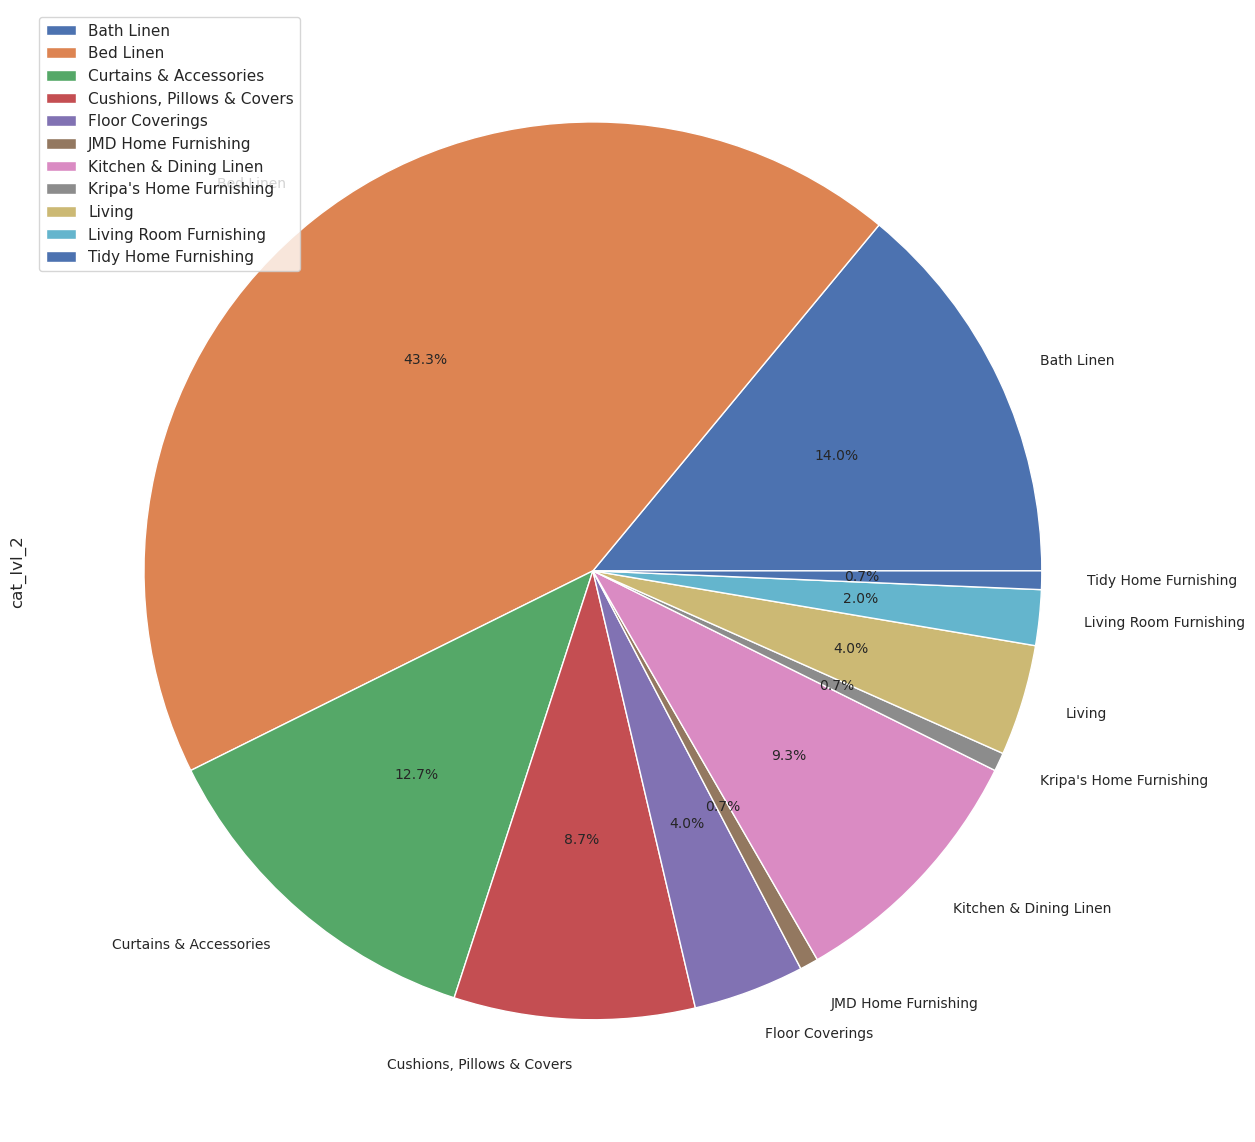

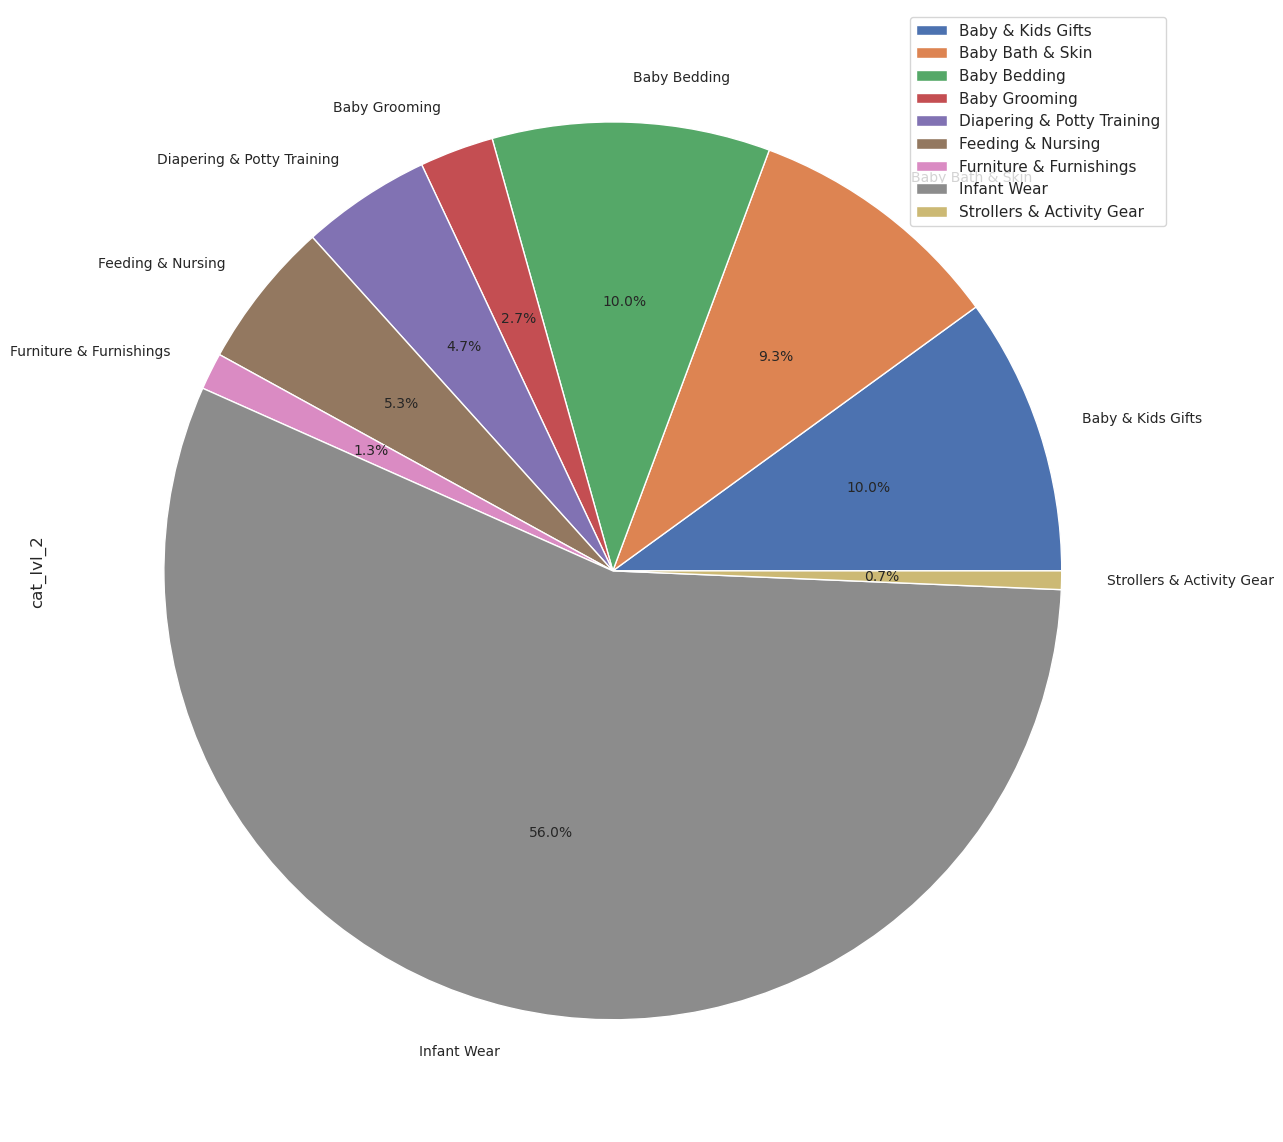

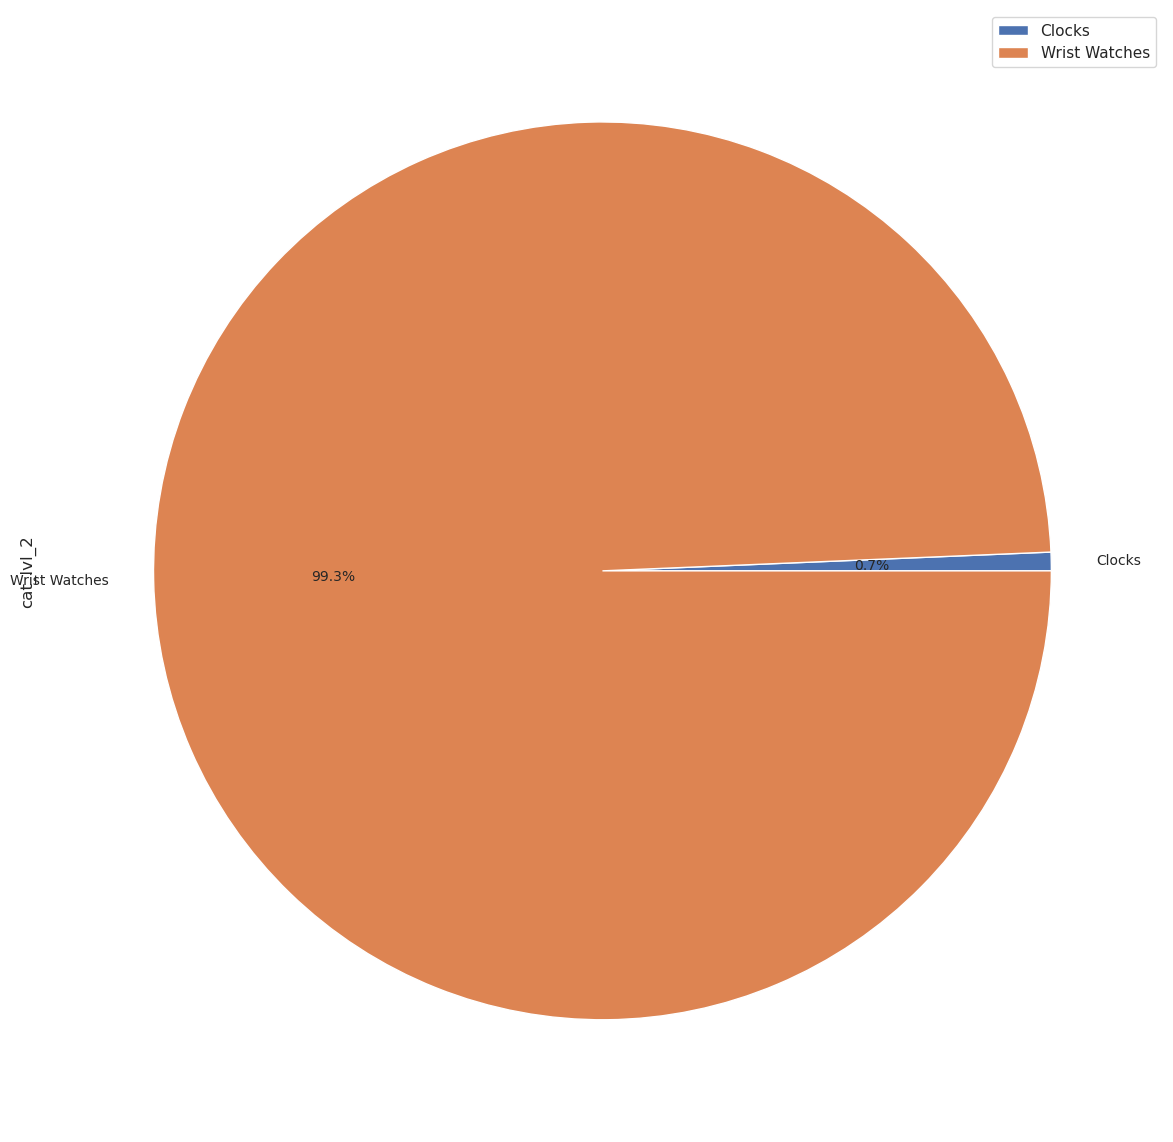

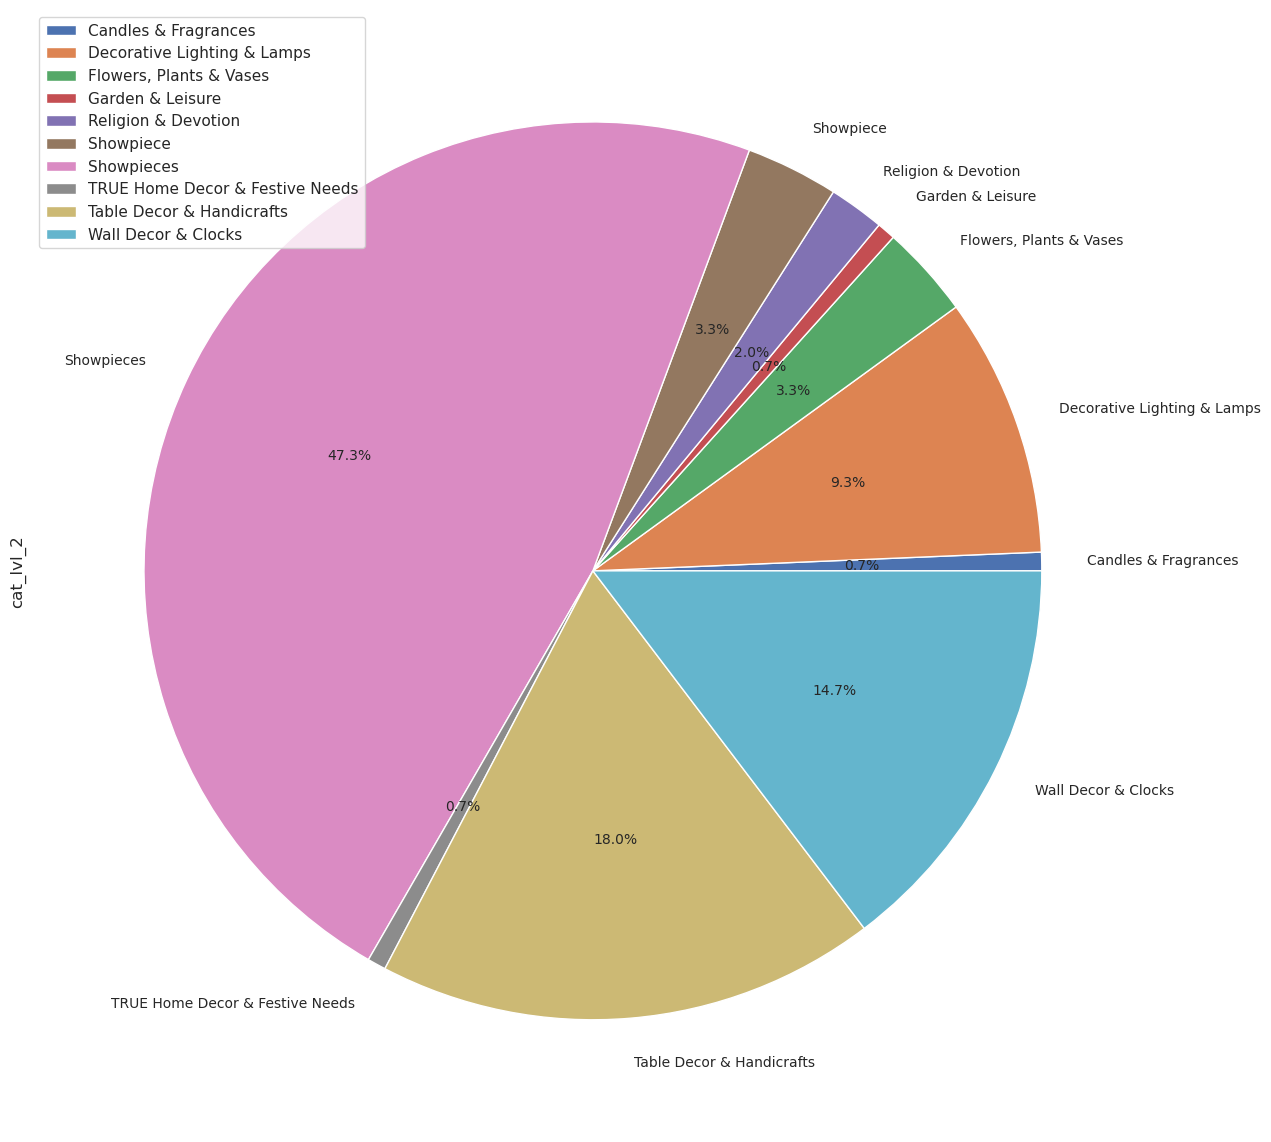

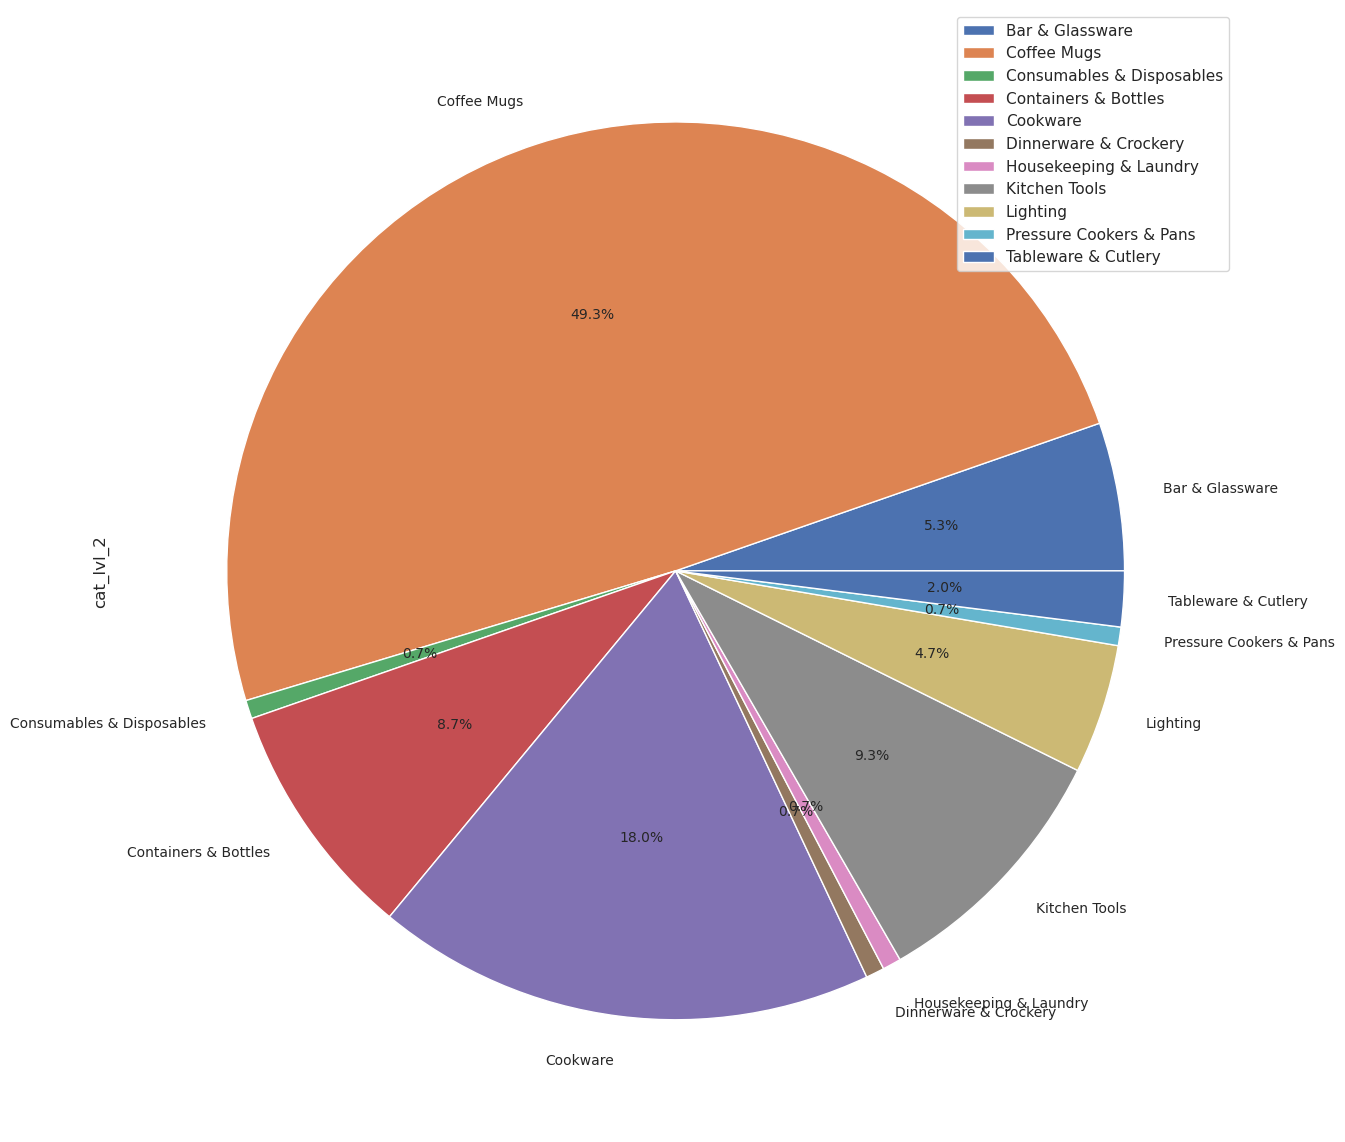

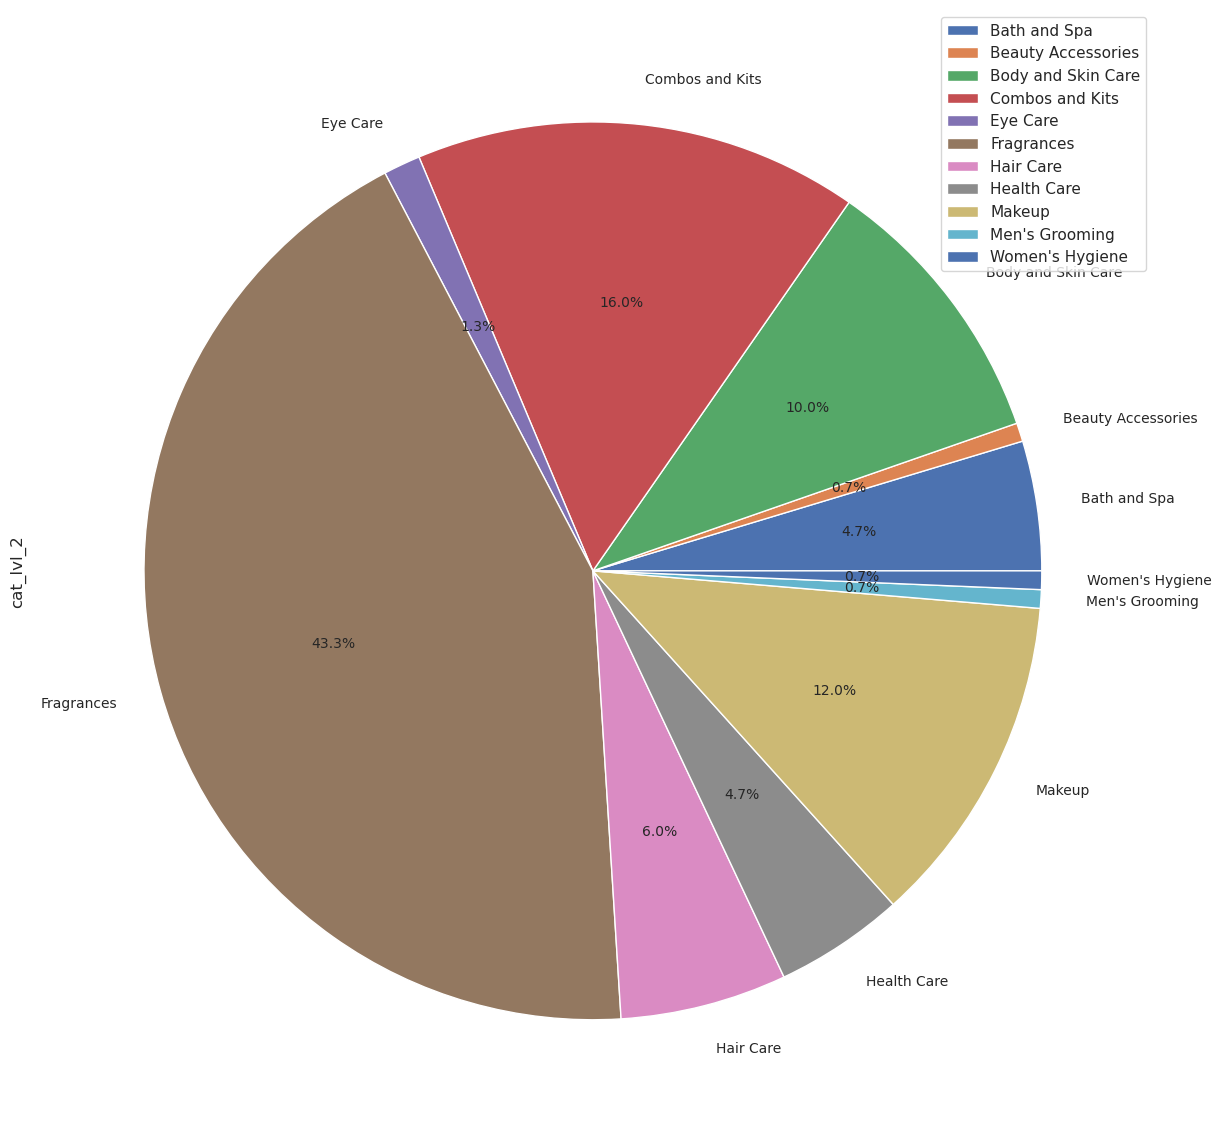

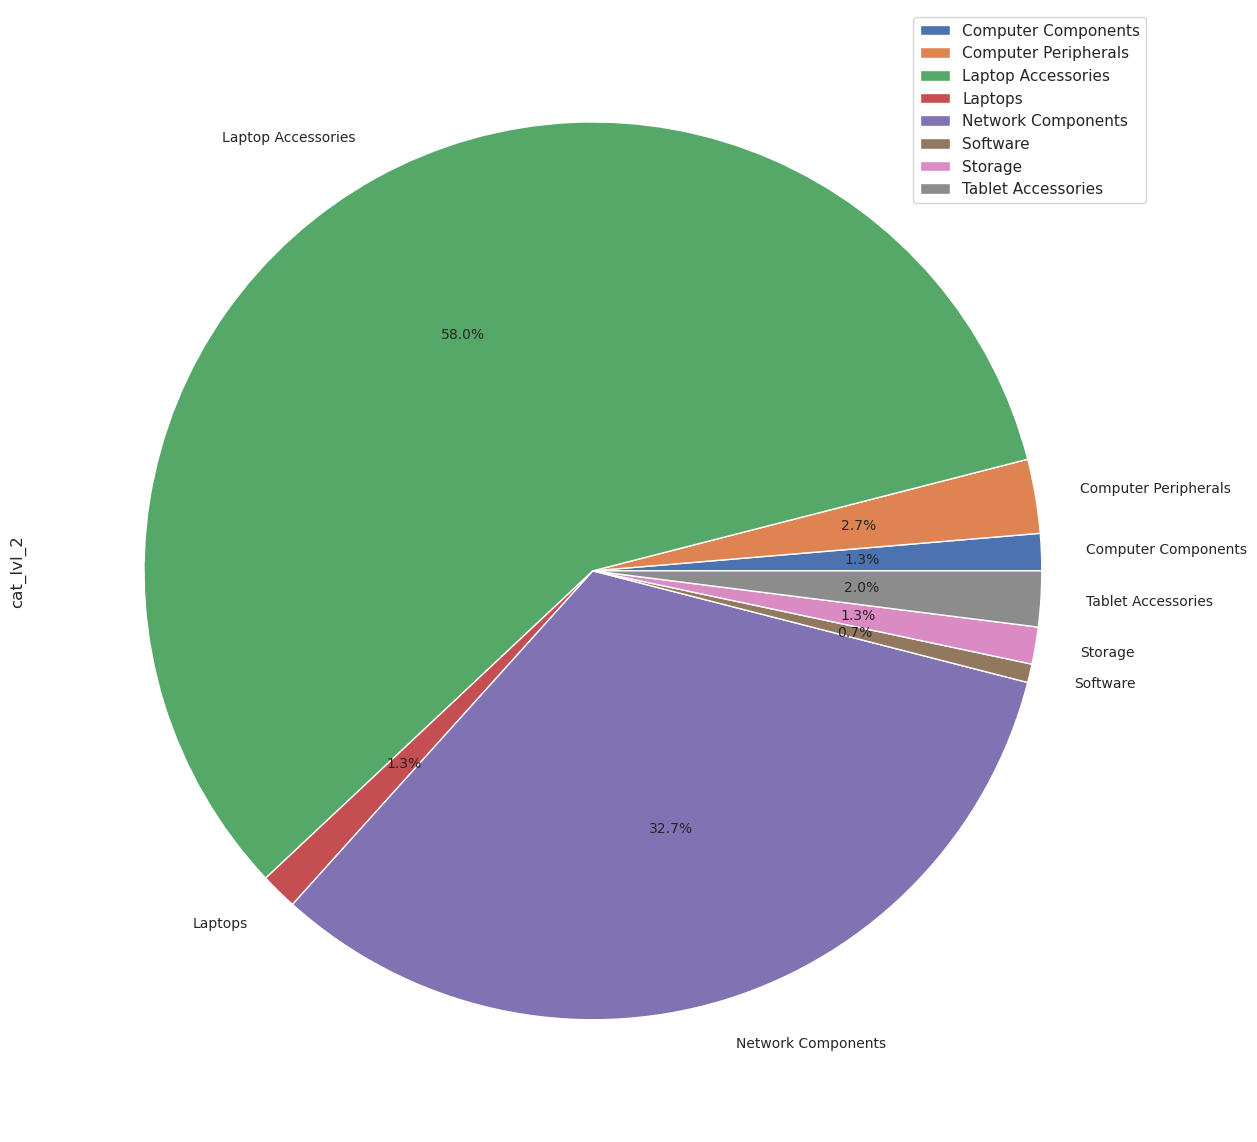

In [37]:
for cat in df_1['cat_lvl_1'].unique() :
    ax = pd.DataFrame(cat_groubed_.loc[cat]).plot(kind='pie', textprops={'size': 'smaller'},
                          subplots=True, rot=0, figsize=(20, 80), layout=(7, 1),legend=True, autopct='%1.1f%%')

    ax = plt.gca()
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
    ax.legend(loc="best")
    ax.set_title(cat)

    #plt.show()
    plt.tight_layout()


In [38]:
#Encodage de la variable cat_lvl_1
le = preprocessing.LabelEncoder()
le.fit(df_1['cat_lvl_1'])
df_1["label"] = le.transform(df_1["cat_lvl_1"])

In [39]:
df_1['label'].value_counts()

4    150
0    150
6    150
3    150
5    150
1    150
2    150
Name: label, dtype: int64

In [40]:
df_1[["label","cat_lvl_1"]].sample(15)

label                   cat_lvl_1
776      0                   Baby Care
876      4             Home Furnishing
465      0                   Baby Care
978      5            Kitchen & Dining
689      5            Kitchen & Dining
514      6                     Watches
456      4             Home Furnishing
96       3  Home Decor & Festive Needs
616      0                   Baby Care
23       6                     Watches
756      4             Home Furnishing
463      1    Beauty and Personal Care
111      3  Home Decor & Festive Needs
782      6                     Watches
794      1    Beauty and Personal Care

In [41]:
df_1['product_name']

0              Elegance Polyester Multicolor Abstract Eyelet Door Curtain
1                                              Sathiyas Cotton Bath Towel
2                                     Eurospa Cotton Terry Face Towel Set
3         SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet
4                   Jaipur Print Cotton Floral King sized Double Bedsheet
                                      ...                                
1045                       Oren Empower Extra Large Self Adhesive Sticker
1046                               Wallmantra Large Vinyl Sticker Sticker
1047    Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker
1048                              Wallmantra Medium Vinyl Sticker Sticker
1049                                         Uberlyfe Large Vinyl Sticker
Name: product_name, Length: 1050, dtype: object

In [42]:
df_1['description']

0       Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...
1       Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...
2       Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...
3       Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet P...
4       Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print C...
                                                       ...                                                 
1045    Oren Empower Extra Large Self Adhesive Sticker (Pack of 2)\r\n                         Price: Rs...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack of 1)\r\n                         Price: Rs. 1,896\...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl Films (Imported) Sticker for Rs.1449 online. Uberly...
1048    Buy Wallmantra Mediu

In [43]:
df_1['product_url']

0       http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...
1                http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH
2       http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y
3       http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt...
4       http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v...
                                                       ...                                                 
1045    http://www.flipkart.com/oren-empower-extra-large-self-adhesive-sticker/p/itme88zgzgcvtbpx?pid=ST...
1046         http://www.flipkart.com/wallmantra-large-vinyl-sticker/p/itmec889fxheshyg?pid=STIEC889ZD5GDCVQ
1047    http://www.flipkart.com/uberlyfe-extra-large-pigmented-polyvinyl-films-imported-sticker/p/itme5u...
1048        http://www.flipk

In [44]:
df_1['description'].max()

'fastrack 38015PL01 Analog Watch  - For Men, Boys - Buy fastrack 38015PL01 Analog Watch  - For Men, Boys  38015PL01 Online at Rs.2495 in India Only at Flipkart.com. Stainless steel back cover. Hybrid case construction for a sportier and more rugged look with increased shock resistance. High precision quartz analogue movement. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!'

In [45]:
#df_1.to_csv('')

### Découpage du jeu de données : X_train et X_test

In [46]:
#données d'entraînement(80%) et données de test(20%)
X = df_1.drop('label', axis=1)
y = df_1['label']

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20)
train_index, test_index = list(split.split(X, y))[0]
len(train_index), len(test_index)

(840, 210)

In [47]:
X_train, y_train = X.iloc[train_index, :], y[train_index]
X_test, y_test = X.iloc[test_index, :], y[test_index]
y_train.shape, y_test.shape

((840,), (210,))

In [48]:
X_train.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_1
Baby Care                     120
Beauty and Personal Care      120
Computers                     120
Home Decor & Festive Needs    120
Home Furnishing               120
Kitchen & Dining              120
Watches                       120
Name: uniq_id, dtype: int64

In [49]:
X_test.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_1
Baby Care                     30
Beauty and Personal Care      30
Computers                     30
Home Decor & Festive Needs    30
Home Furnishing               30
Kitchen & Dining              30
Watches                       30
Name: uniq_id, dtype: int64

### Néttoyage de données textuelles

In [50]:
df_1[['description']].sample(5)

description
391  Buy Asus DSL-N10_C1 only for Rs. 1700 from Flipkart.com. Only Genuine Products. 30 Day Replaceme...
412  Flipkart.com: Buy Denver RO,Spring Combo Set online only for Rs. 349 from Flipkart.com. Only Gen...
474  Key Features of Art n Beyond 150013 Elegant design,Art n Beyond 150013 (300 ml, Clear, Pack of 6...
854  Buy KLIQVIK SIX PORT USB HUB FOR ANDROID MOBILES TR-250 USB USB Hub for Rs.1099 online. KLIQVIK ...
45   Key Features of AKUP i-love-my-mom Ceramic Mug Pack of 1 Mug,AKUP i-love-my-mom Ceramic Mug (300...

### L'ensemble du corpus

In [51]:
#nltk.download()

In [52]:
stopwords_en = set(["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"])
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
stopwords_combined = set.union(stopwords_en, stopwords_nltk, stopwords_punct)

In [53]:
ps = PorterStemmer()
eng_words = [i.lower() for i in words.words()]
eng_words_stem = [ps.stem(i) for i in eng_words]

### Rassemler toutes les descriptions pour former notre corpus

In [54]:
# join all corpus
raw_corpus = " ".join(df_1.description.values)
raw_corpus[:1_000]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [55]:
import fontionsUtiles_texte as fctUtiles

In [56]:
fctUtiles.process_text_slide(raw_corpus)

==================================lower==========================================
nb tokens 498561
====================================tokenize========================================
nb tokens 81563, nb tokens unique 6085
['key', 'features', 'of', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'in', 'height', 'pack', 'of', '2', 'price', 'rs', '899', 'this']
=================================stopwords===========================================
nb tokens 58040, nb tokens unique 5773
['key', 'features', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'rs', '899', 'curtain', 'enhances', 'interiors', 'curtain']
==============================more len words=================

In [57]:
# process the corpus avac WordNetLemmatizer
corpus = fctUtiles.process_text(raw_corpus,
                        rejoin=False,
                        )
fctUtiles.display_tokens_info(corpus)

nb tokens 49807, nb tokens unique 3677
['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhanc', 'interior', 'curtain', 'made', 'high', 'qualiti', 'polyest', 'fabric']


In [58]:
# idem for min 5 items
tmp = pd.Series(corpus).value_counts()

list_unique_words = tmp[tmp == 1]
list_min_5_words = tmp[tmp <= 5]
list_max_100_words = tmp[tmp > 100]
list_max_200_words = tmp[tmp > 200]
list_max_400_words = tmp[tmp > 400]
list_more_words = tmp[tmp > 500]
list_max_450_words = tmp[tmp > 450]
list_max_470_words = tmp[tmp > 470]

In [59]:
print(len(list_unique_words),len(list_min_5_words),len(list_max_100_words),len(list_max_200_words),len(list_more_words))


1003 2556 94 47 10


In [60]:
list_max_470_words[:30]

product     870
free        618
buy         581
replac      570
ship        569
deliveri    567
cash        564
genuin      564
price       561
day         553
flipkart    481
guarante    473
dtype: int64

In [61]:
list_rare_words=list(list_unique_words.index)
list_more_words=list(list_max_470_words.index)

In [62]:
df_1["clean_text"] = df_1.description.parallel_apply(fctUtiles.process_text)

In [63]:
df_1["clean_text"] = df_1.clean_text.parallel_apply(fctUtiles.clean_text, list_rare_words=list_rare_words, list_more_words=list_more_words)

In [64]:
df_1['clean_description'] = df_1['clean_text'].apply(lambda x : fctUtiles.return_sentences(x))

In [65]:
df_1[['description','clean_text','clean_description']].sample(5)

description  \
115  Filink 310 Black Toner (Black)\r\n                         Price: Rs. 1,390\r\n\t\t\t\t\r\n\t\t\...   
281  Bhavya Velvet Sofa Cover (Grey Pack of 10) Price: Rs. 1,999 Bhavya Velvet Sofa Cover (Black Pack...   
317  Flipkart.com: Buy Archies VJ-552 Combo Set online only for Rs. 399 from Flipkart.com. Only Genui...   
427  Key Features of Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR540E/L 75 Adapter ...   
923  Buy Pinc Ginger 90.6 inch Black, White Rice Lights for Rs.3000 online. Pinc Ginger 90.6 inch Bla...   

                                                                                              clean_text  \
115  [black, toner, black, compat, printer, canon, lbp, consist, high, qualiti, print, high, page, yi...   
281  [bhavya, velvet, sofa, cover, grey, pack, bhavya, velvet, sofa, cover, black, pack, specif, bhav...   
317                                                                           [archi, combo, set, onlin]   
427  [key, featur, smartpro, charger, vaio, seri, vgn, adapt, design, soni, vaio, vgn, smartpro, char...   
923  [pinc, ginger, inch, black, white, rice, light, onlin, pinc, ginger, inch, black, white, rice, l...   

                                                                                       clean_description  
115  black toner black compat printer canon lbp consist high qualiti print high page yield dark print...  
281  bhavya velvet sofa cover grey pack bhavya velvet sofa cover black pack specif bhavya velvet sofa...  
317                                                                                archi combo set onlin  
427  key featur smartpro charger vaio seri vgn adapt design soni vaio vgn smartpro charger vaio seri ...  
923                pinc ginger inch black white rice light onlin pinc ginger inch black white rice light

In [66]:
df_1[df_1.clean_description == ''][['cat_lvl_1','description']]

cat_lvl_1  \
333  Computers   
380  Computers   
383  Computers   
403  Computers   
413  Computers   

                                                                                             description  
333  Buy Binatone WR3000N only for Rs. 1800 from Flipkart.com. Only Genuine Products. 30 Day Replacem...  
380  Buy iBall wr7011a only for Rs. 1333 from Flipkart.com. Only Genuine Products. 30 Day Replacement...  
383  Buy Netis WF-2301 only for Rs. 5249 from Flipkart.com. Only Genuine Products. 30 Day Replacement...  
403  Buy Airtel B310s-927 only for Rs. 2700 from Flipkart.com. Only Genuine Products. 30 Day Replacem...  
413  Buy Digisol DG-BG4100N only for Rs. 1470 from Flipkart.com. Only Genuine Products. 30 Day Replac...

In [67]:
df_1[df_1.clean_description == ''][['cat_lvl_1','description','clean_description']]

cat_lvl_1  \
333  Computers   
380  Computers   
383  Computers   
403  Computers   
413  Computers   

                                                                                             description  \
333  Buy Binatone WR3000N only for Rs. 1800 from Flipkart.com. Only Genuine Products. 30 Day Replacem...   
380  Buy iBall wr7011a only for Rs. 1333 from Flipkart.com. Only Genuine Products. 30 Day Replacement...   
383  Buy Netis WF-2301 only for Rs. 5249 from Flipkart.com. Only Genuine Products. 30 Day Replacement...   
403  Buy Airtel B310s-927 only for Rs. 2700 from Flipkart.com. Only Genuine Products. 30 Day Replacem...   
413  Buy Digisol DG-BG4100N only for Rs. 1470 from Flipkart.com. Only Genuine Products. 30 Day Replac...   

    clean_description  
333                    
380                    
383                    
403                    
413

In [68]:
df_1.drop(df_1[df_1.clean_description == ''].index, axis=0, inplace=True)

In [69]:
df_1.shape

(1045, 20)

In [70]:
df_1 = df_1.reset_index(drop=True)

### Nuage de mots

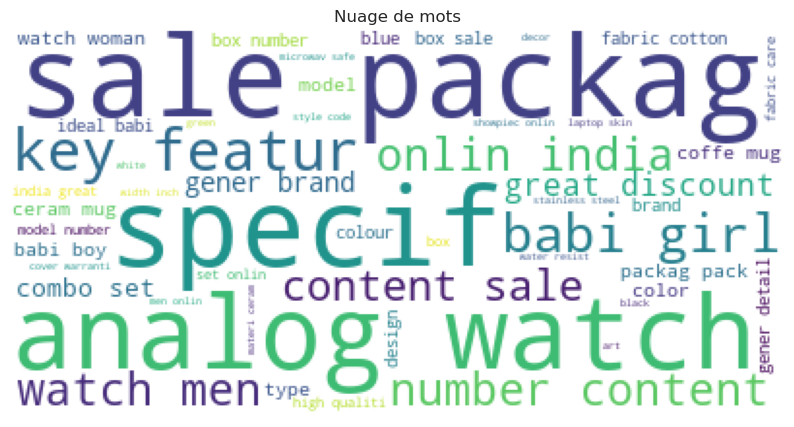

In [71]:
# nuage des mots
plt.figure(figsize=(10,10))
#plt.subplot(121)
wordcloud = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(df_1.clean_description.values))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Nuage de mots')

plt.show()

In [72]:
category_0 = df_1[df_1.label == 0]
category_1 = df_1[df_1.label == 1]
category_2 = df_1[df_1.label == 2]
category_3 = df_1[df_1.label == 3]
category_4 = df_1[df_1.label == 4]
category_5 = df_1[df_1.label == 5]
category_6 = df_1[df_1.label == 6]

In [73]:
corpus_0 = category_0.clean_description
corpus_1 = category_1.clean_description
corpus_2 = category_2.clean_description
corpus_3 = category_3.clean_description
corpus_4 = category_4.clean_description
corpus_5 = category_5.clean_description
corpus_6 = category_6.clean_description


In [74]:
#Par catégories
wordcloud_0 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_0))
wordcloud_1 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_1))
wordcloud_2 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_2))
wordcloud_3 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_3))
wordcloud_4 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_4))
wordcloud_5 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_5))

wordcloud_6 = WordCloud(background_color='white',
                     stopwords=[],
                     max_words=50).generate(" ".join(corpus_6))


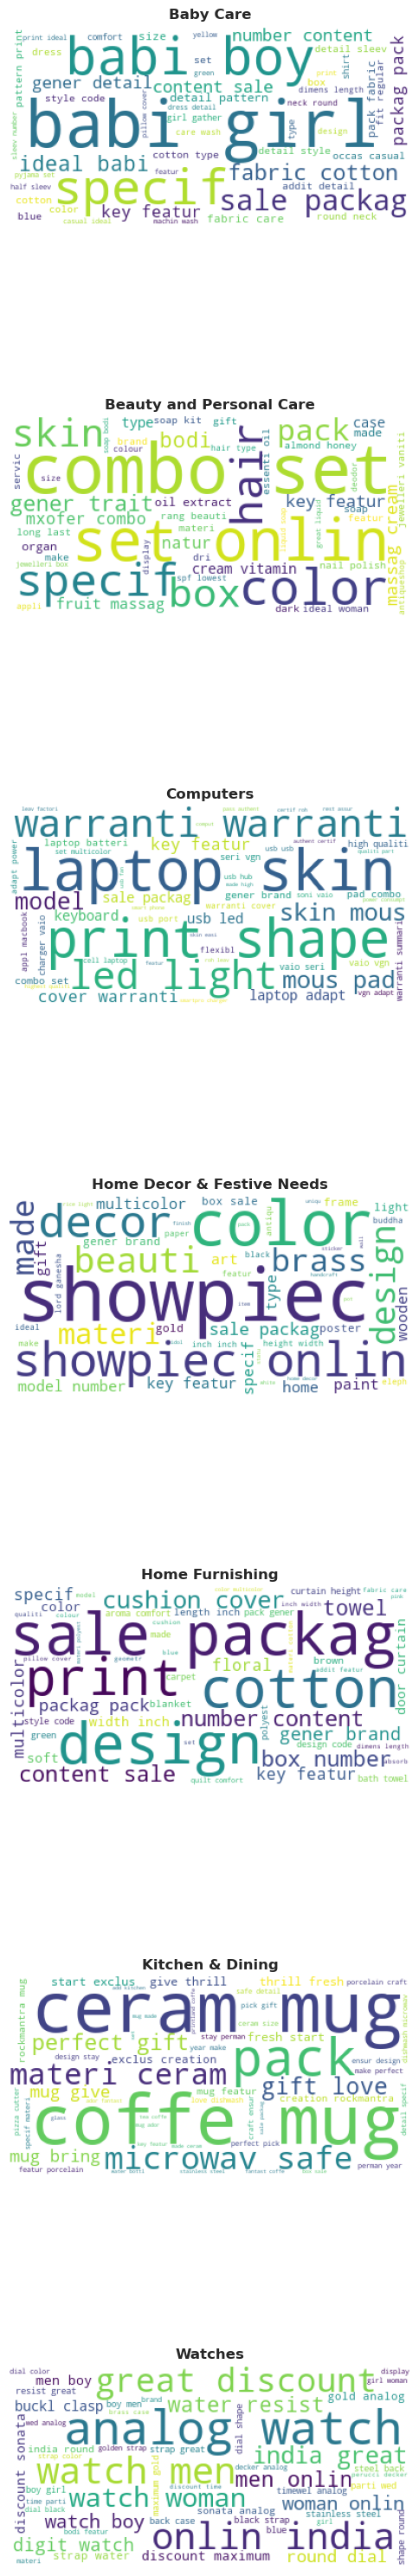

In [75]:
#Visualisation
fig, axes = plt.subplots(7, 1, sharex=True, figsize=(6, 40)) #figsize=(15, 25)

#fig.suptitle('Nuages de mots par catégories', fontweight="bold")

sns.boxplot(ax=axes[0]).imshow(wordcloud_0)
axes[0].set_title('Baby Care', fontweight="bold")
axes[0].axis('off')



sns.boxplot(ax=axes[1]).imshow(wordcloud_1)
axes[1].set_title('Beauty and Personal Care', fontweight="bold")
axes[1].axis('off')


sns.boxplot(ax=axes[2]).imshow(wordcloud_2)
axes[2].set_title('Computers', fontweight="bold")
axes[2].axis('off')


sns.boxplot(ax=axes[3]).imshow(wordcloud_3)
axes[3].set_title('Home Decor & Festive Needs', fontweight="bold")
axes[3].axis('off')


sns.boxplot(ax=axes[4]).imshow(wordcloud_4)
axes[4].set_title('Home Furnishing', fontweight="bold")
axes[4].axis('off')


sns.boxplot(ax=axes[5]).imshow(wordcloud_5)
axes[5].set_title('Kitchen & Dining', fontweight="bold")
axes[5].axis('off')


sns.boxplot(ax=axes[6]).imshow(wordcloud_6)
axes[6].set_title('Watches', fontweight="bold")
axes[6].axis('off')

#plt.title('Nuages de mots par catégories', fontweight="bold")
plt.show()

### Fréquence des mots

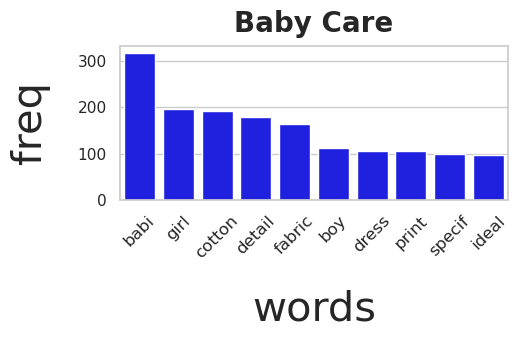

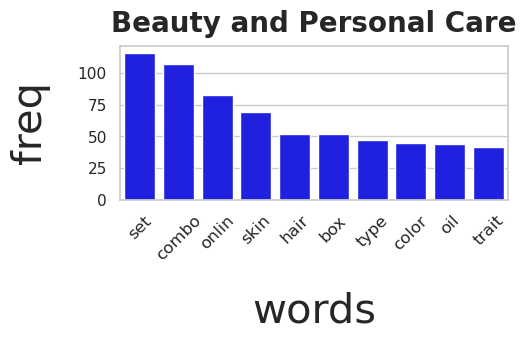

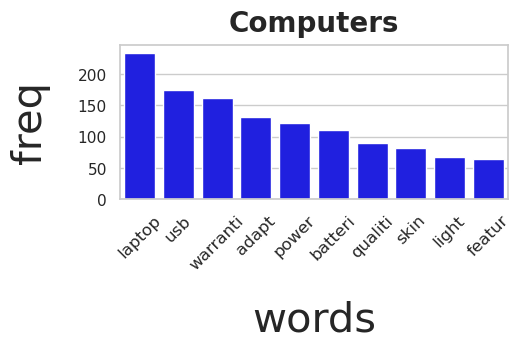

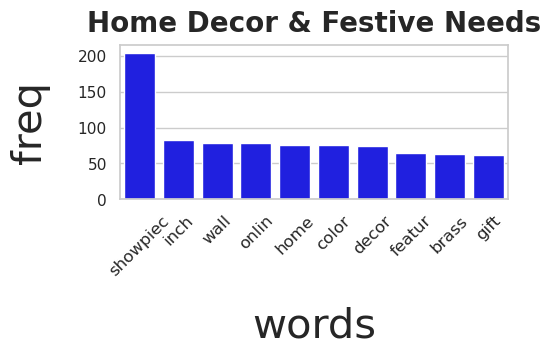

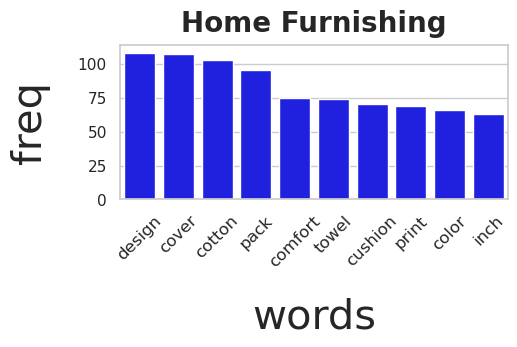

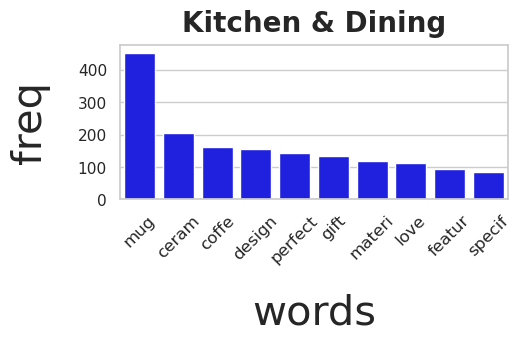

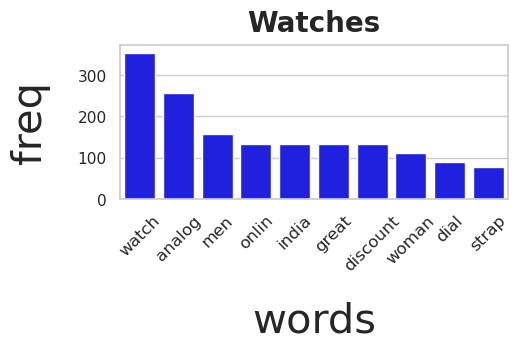

In [76]:
dfs_freq = pd.DataFrame()

for cat1, data_df in df_1.groupby("cat_lvl_1"):
    df_freq = fctUtiles.freqence_words(data_df["clean_text"], 10).reset_index()
    df_freq["Category"] = cat1
    dfs_freq= pd.concat([dfs_freq, df_freq])
    fctUtiles.plot_freq_dist(df_freq, cat1 , 5, 2)

### Split

In [77]:
#données d'entraînement(80%) et données de test(20%)
X = df_1.drop('label', axis=1)
y = df_1['label']

In [78]:

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20)
train_index, test_index = list(split.split(X, y))[0]
len(train_index), len(test_index)



(836, 209)

In [79]:
X_train, y_train = X.iloc[train_index, :], y[train_index]
X_test, y_test = X.iloc[test_index, :], y[test_index]
y_train.shape, y_test.shape



((836,), (209,))

In [80]:
X_train.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)


cat_lvl_1
Baby Care                     120
Beauty and Personal Care      120
Home Decor & Festive Needs    120
Home Furnishing               120
Kitchen & Dining              120
Watches                       120
Computers                     116
Name: uniq_id, dtype: int64

In [81]:
X_test.groupby('cat_lvl_1').count()['uniq_id'].sort_values(ascending=False)

cat_lvl_1
Baby Care                     30
Beauty and Personal Care      30
Home Decor & Festive Needs    30
Home Furnishing               30
Kitchen & Dining              30
Watches                       30
Computers                     29
Name: uniq_id, dtype: int64

### Bag of words : TF et TF-IDF

In [82]:
# Tf
tf_vectorizer = CountVectorizer(encoding='utf-8', stop_words='english', max_df=0.95, min_df=5)
#Tf_idf
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8', stop_words='english', max_df=0.95, min_df=5)

#### TF 

In [83]:
X_tf = tf_vectorizer.fit_transform(df_1['clean_description']).toarray() 

#X_train_tf = tf_vectorizer.fit_transform(X_train['clean_description'])
#X_test_tf = tf_vectorizer.fit_transform(X_test['clean_description'])

In [84]:
X_tf.shape #,X_train_tf.shape,X_test_tf.shape

(1045, 811)

In [85]:
# Dataframe in BOW 
words = tf_vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_tf , columns=words)
bow_df.shape

(1045, 811)

In [86]:
bow_df.head()

absorb  abstract  accessori  actual  adapt  add  addit  adhes  adida  \
0       0         4          0       0      0    0      0      0      0   
1       0         0          0       0      0    0      0      0      0   
2       1         0          0       0      0    0      0      0      0   
3       0         0          0       0      0    0      0      0      0   
4       0         0          0       0      0    0      0      0      0   

   adjust  ...  wire  wireless  woman  wood  wooden  work  world  wrap  year  \
0       0  ...     0         0      0     0       0     0      1     0     0   
1       0  ...     0         0      1     0       0     0      0     0     0   
2       0  ...     0         0      1     0       0     0      0     0     1   
3       0  ...     0         0      0     0       0     0      0     0     0   
4       0  ...     0         0      0     0       0     0      0     0     0   

   yellow  
0       0  
1       2  
2       0  
3       0  
4       0  

[5 rows x 811 columns]

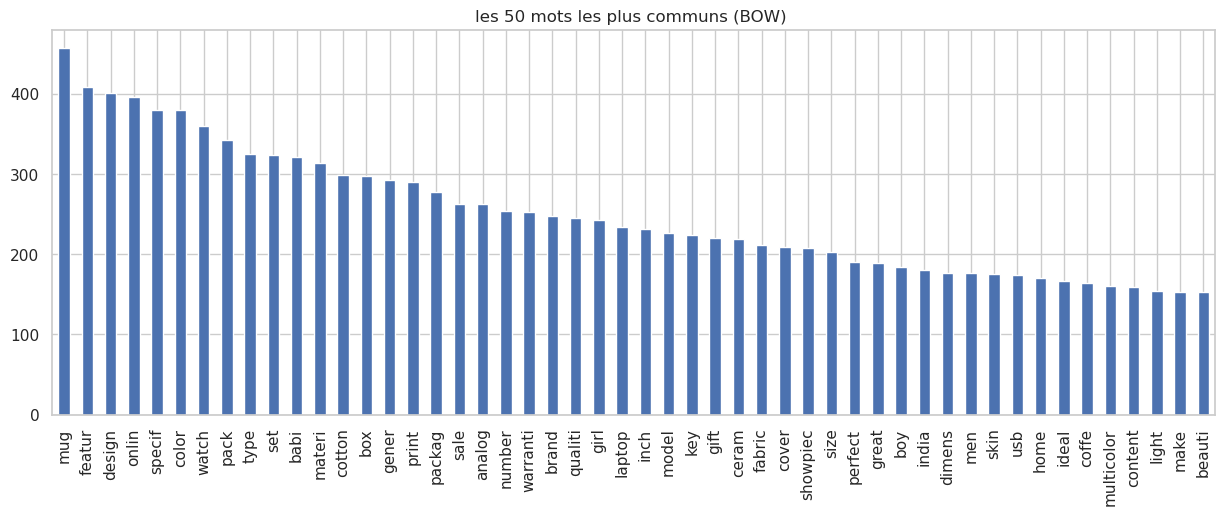

In [87]:
plt.title('les 50 mots les plus communs (BOW) ')
bow_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

#### TF-IDF

In [88]:
X_tfidf = tfidf_vectorizer.fit_transform(df_1['clean_description']).todense()
#X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['clean_description'])
#X_test_tfidf = tfidf_vectorizer.fit_transform(X_test['clean_description'])

In [89]:
X_tfidf.shape#, X_train_tfidf.shape, X_test_tfidf.shape

(1045, 811)

In [90]:
# Dataframe in TF-IDF form
words = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X_tfidf, columns=words)
tfidf_df.shape

(1045, 811)

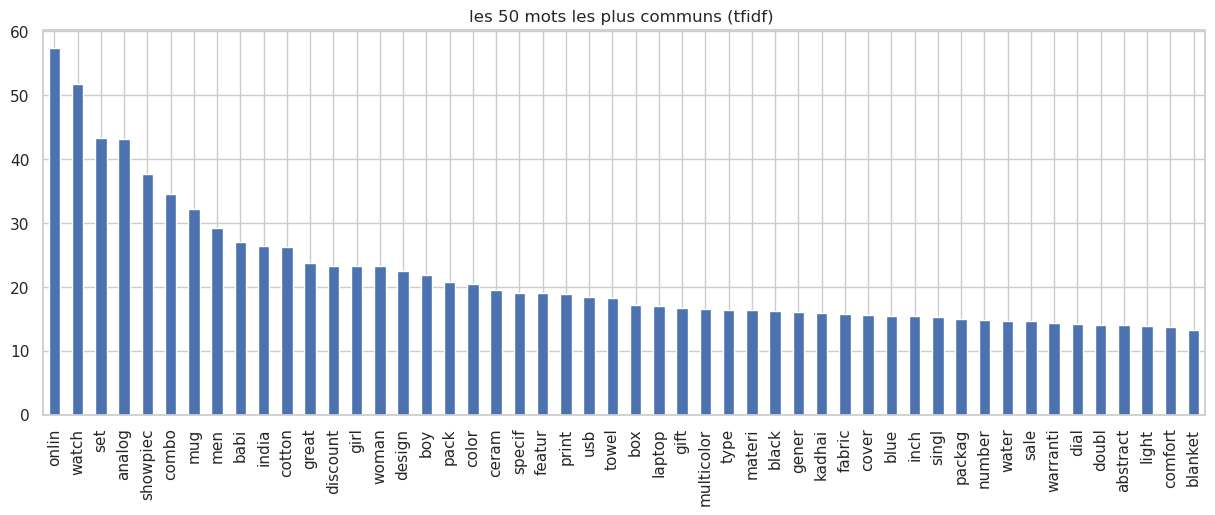

In [91]:
plt.title('les 50 mots les plus communs (tfidf) ')
tfidf_df.sum(axis=0).sort_values(ascending=False)[:50].plot.bar(figsize=(15,5))
plt.show()

In [92]:
matrix_cat = tfidf_vectorizer.fit_transform(df_1['clean_description'])

In [93]:
#matrix_cat = X_tfidf
transformation = []
for i, el  in enumerate(matrix_cat.todense()[4,:].tolist()[0]):
    if el !=0:
        transformation.append((tfidf_vectorizer.get_feature_names_out()[i], el))
tfidf_df_2 = pd.DataFrame(transformation, columns=['mot', 'tfidf']).sort_values(by='tfidf', ascending=False)
tfidf_df_2.head(5)

mot     tfidf
47     sheet  0.551893
1   bedsheet  0.280572
41    pillow  0.276713
0        bed  0.258139
28    jaipur  0.250247

### Réduction de dimension 

#### Standardisation des données

In [94]:
standardScaler = StandardScaler()
#TF
X_tf = np.asarray(X_tf)
X_tf = standardScaler.fit_transform(X_tf)
#TF-IDF
X_tfidf = np.asarray(X_tfidf)
X_tfidf = standardScaler.fit_transform(X_tfidf)

#### PCA

#### Bag of words : TF

In [95]:
print("Dimensions dataset avant réduction PCA : ", X_tf.shape)
pca = decomposition.PCA(n_components=0.99)
X_tf_reduce = pca.fit_transform(X_tf)
print("Dimensions dataset après réduction PCA : ", X_tf_reduce.shape)

Dimensions dataset avant réduction PCA :  (1045, 811)
Dimensions dataset après réduction PCA :  (1045, 408)


In [96]:
print("Dimensions dataset avant réduction PCA : ", X_tf.shape)
pca = decomposition.PCA(n_components=0.90)
X_tf_reduce_90 = pca.fit_transform(X_tf)
print("Dimensions dataset après réduction PCA : ", X_tf_reduce_90.shape)

Dimensions dataset avant réduction PCA :  (1045, 811)
Dimensions dataset après réduction PCA :  (1045, 213)


#### TF-IDF

In [97]:
print("Dimensions dataset avant réduction PCA : ", X_tfidf.shape)
pca = decomposition.PCA(n_components=0.99)
X_tfidf_reduce = pca.fit_transform(X_tfidf)
print("Dimensions dataset après réduction PCA : ", X_tfidf_reduce.shape)

Dimensions dataset avant réduction PCA :  (1045, 811)
Dimensions dataset après réduction PCA :  (1045, 511)


In [98]:
print("Dimensions dataset avant réduction PCA : ", X_tfidf.shape)
pca = decomposition.PCA(n_components=0.90)
X_tfidf_reduce_90 = pca.fit_transform(X_tfidf)
print("Dimensions dataset après réduction PCA : ", X_tfidf_reduce_90.shape)

Dimensions dataset avant réduction PCA :  (1045, 811)
Dimensions dataset après réduction PCA :  (1045, 313)


#### T-NSE

##### TF

In [99]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_tf = tsne.fit_transform(X_tf_reduce_90)

df_tsne_tf = pd.DataFrame(tsne_tf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tf["class"] = df_1["cat_lvl_1"]
print(df_tsne_tf.shape)

(1045, 3)


##### Visualisation

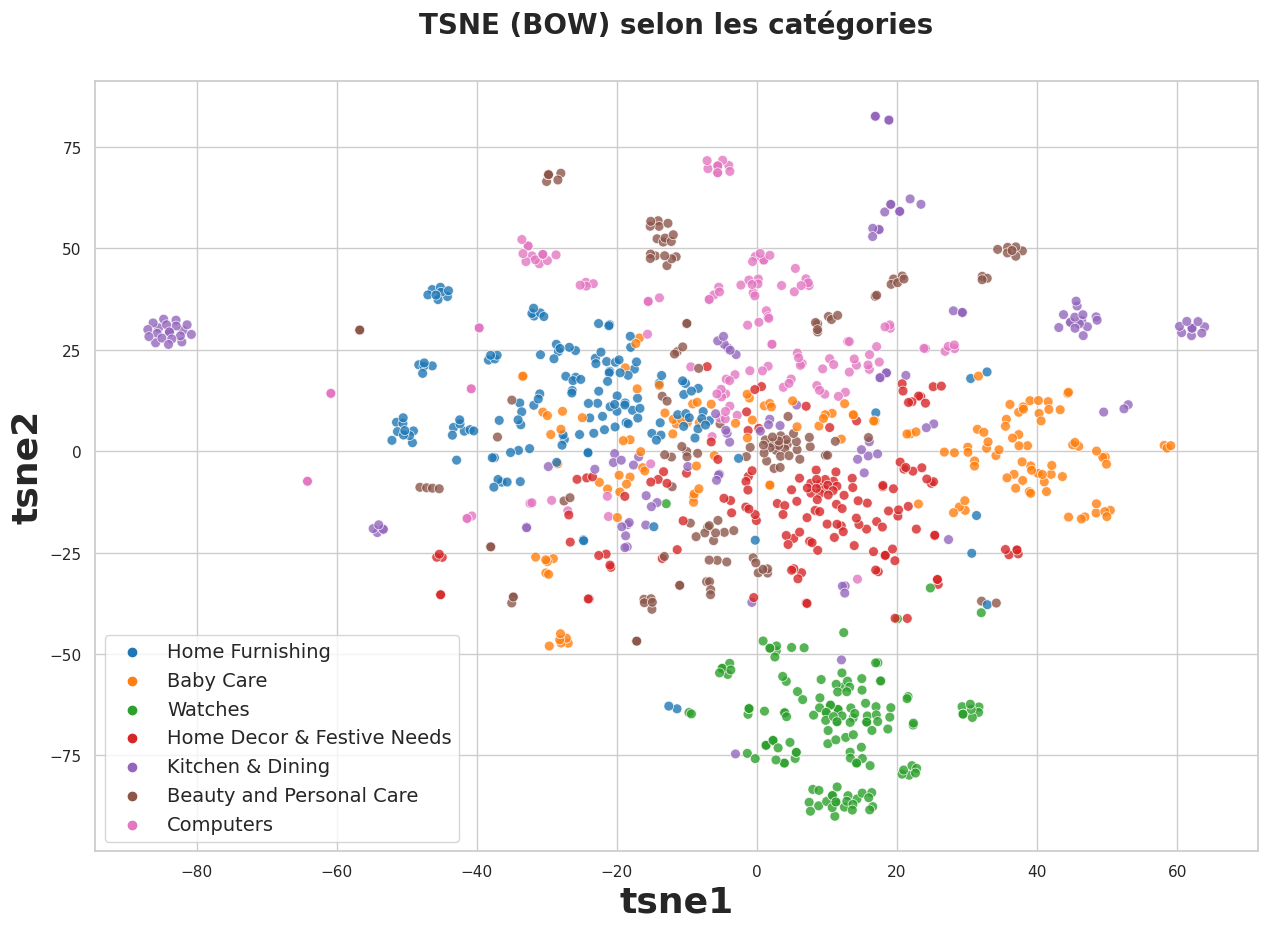

In [100]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

##### TF-IDF

In [101]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_tfidf = tsne.fit_transform(X_tfidf_reduce_90)

df_tsne_tfidf = pd.DataFrame(tsne_tfidf[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_tfidf["class"] = df_1["cat_lvl_1"]
print(df_tsne_tfidf.shape)

(1045, 3)


##### Visualisation

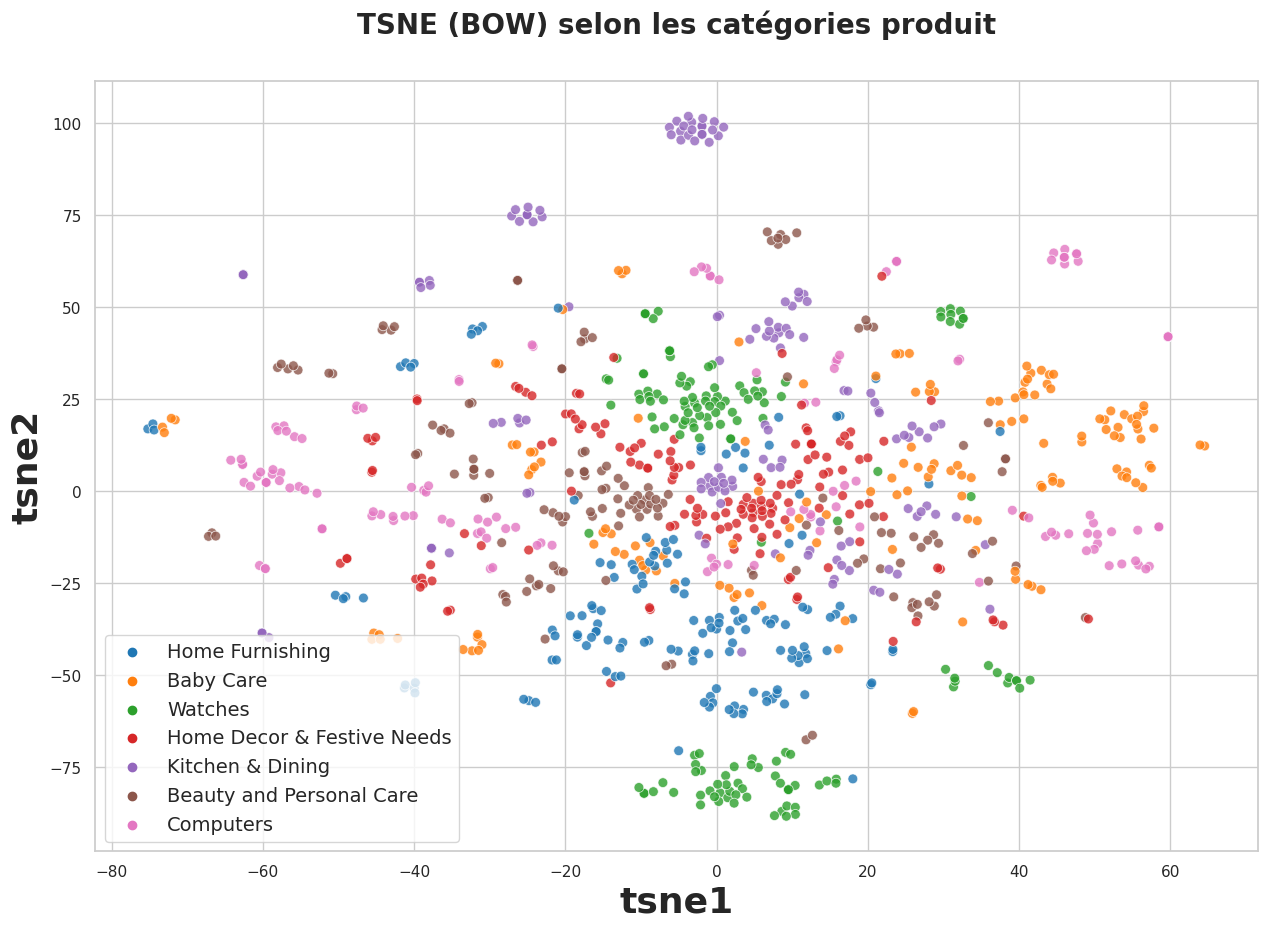

In [102]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

### CLUSTERING
#### K-Means classification

In [103]:
df_resultats = pd.DataFrame()



def add_model_score(df: pd.DataFrame = None, model_name: str = 'none', ARI: float = 0, **kwargs):
    global df_resultats
    if df is None:
        df = df_resultats
    """ajout les resultats d'un model """
    resultats = dict(model=model_name, ARI=ARI)
    resultats = dict(**resultats, **kwargs)
    df = df.append(resultats, ignore_index=True)
    return df

In [104]:
# On a 7 catégories produit
N_CLUSTERS = 7 

###### TF

In [105]:
#Création de clusters à partir du T-SNE 
X = df_tsne_tf[["tsne1","tsne2"]]

cls = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls.fit(X)

df_tsne_tf["cluster"] = cls.labels_

sil = silhouette_score(X,cls.labels_,metric="euclidean")
print("========================================")
print("Le score de silhouette est",round( sil,2))
print("========================================")

Le score de silhouette est 0.39


/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [106]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Baby Care': 0, 'Beauty and Personal Care': 1, 'Computers': 2, 'Home Decor & Festive Needs': 3, 'Home Furnishing': 4, 'Kitchen & Dining': 5, 'Watches': 6}


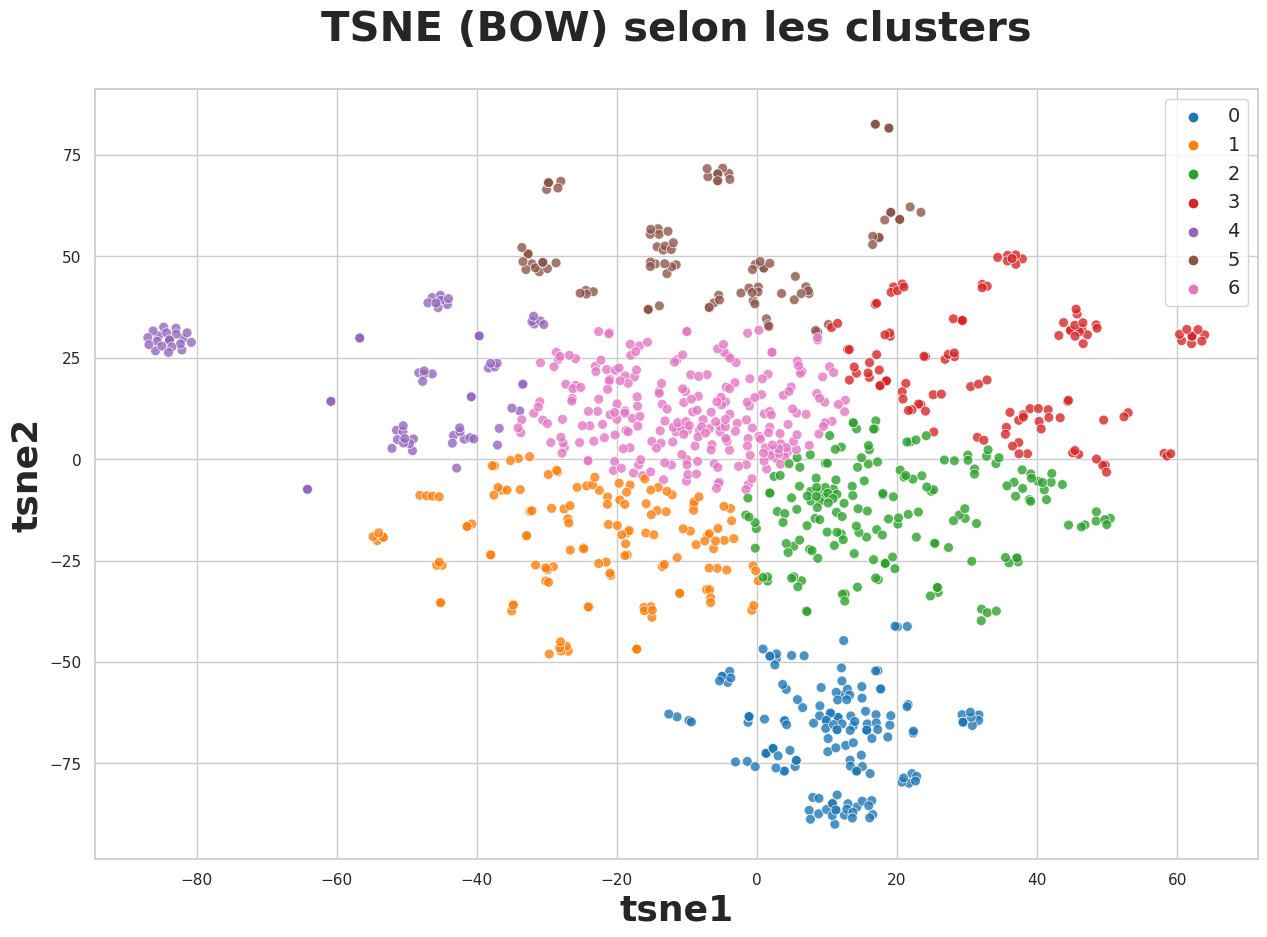

ARI  :  0.26654886593279337


In [107]:
#Affichage des catégories selon clusters et calcul ARI de similarité catégories produit / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_tf,
    legend="brief")

plt.title('TSNE (BOW) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = df_1["label"]
print("ARI  : ", metrics.adjusted_rand_score(labels, cls.labels_))

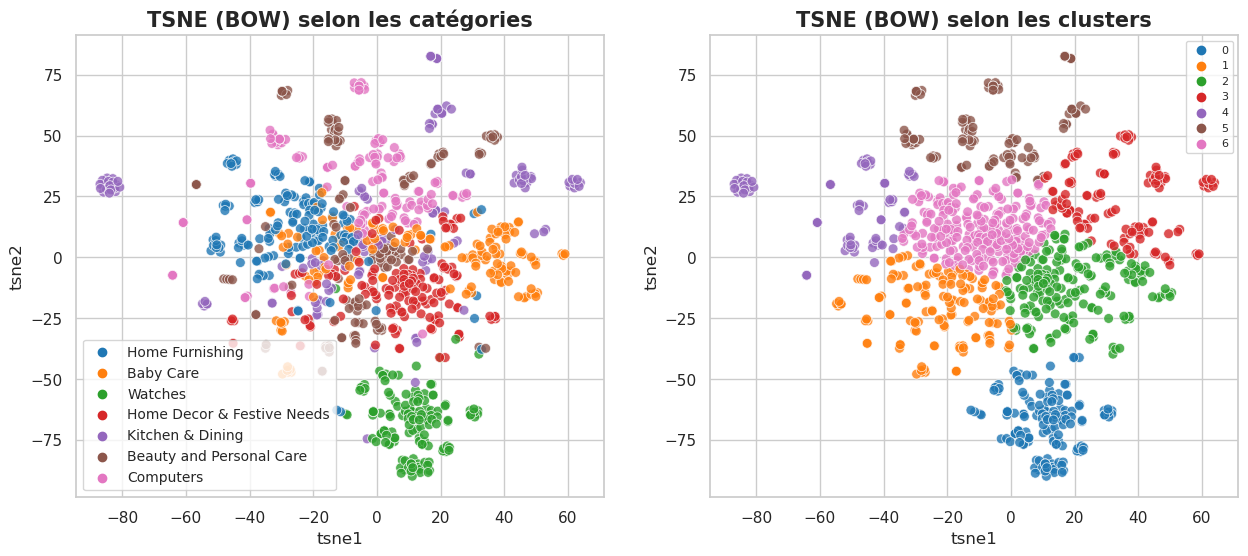

ARI :  0.267


/home/mel/OpenClassrooms/ocr_projet_6/Projet_6/fontionsUtiles_texte.py:504: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(resultats, ignore_index=True)


In [108]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_tf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BOW) selon les catégories', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_tf,
legend="brief")

plt.title('TSNE (BOW) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_bow=round( metrics.adjusted_rand_score(labels, cls.labels_),3)
labels = df_1["label"]
print(f"ARI : ",ARI_bow)
df_resultats = fctUtiles.add_model_score(df_resultats, model_name='BOW ', ARI=ARI_bow)

In [109]:
df_resultats

model    ARI
0  BOW   0.267

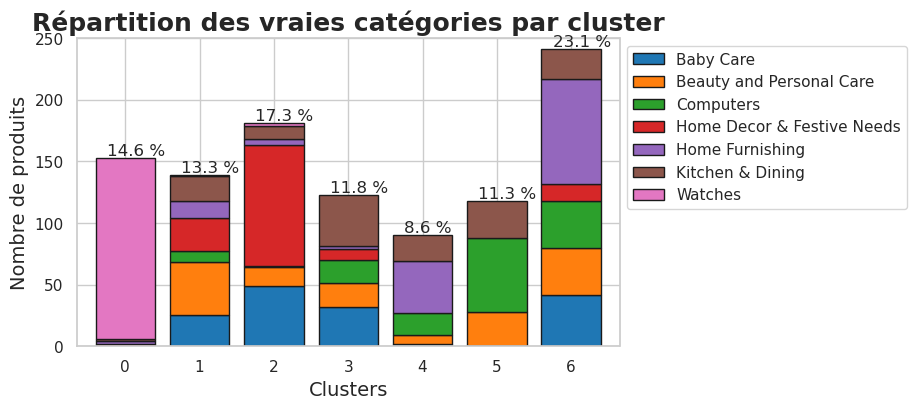

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               0.0                       0.0        0.0   
1              25.0                      43.0        9.0   
2              49.0                      15.0        1.0   
3              32.0                      19.0       19.0   
4               2.0                       7.0       18.0   
5               0.0                      28.0       60.0   
6              42.0                      38.0       38.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                2.0              2.0               2.0   
1                               27.0             14.0              20.0   
2                               98.0              5.0              11.0   
3                                9.0              2.0              42.0   
4                                0.0             42.0              21.0   
5                                0.0              0.0              30.0   
6                               14.0             85.0              24.0   

category  Watches  
label              
0           147.0  
1             1.0  
2             2.0  
3             0.0  
4             0.0  
5             0.0  
6             0.0

In [110]:
fctUtiles.plot_clust_vs_cat(df_tsne_tf["cluster"],
                              df_tsne_tf["class"],
                              df_tsne_tf,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

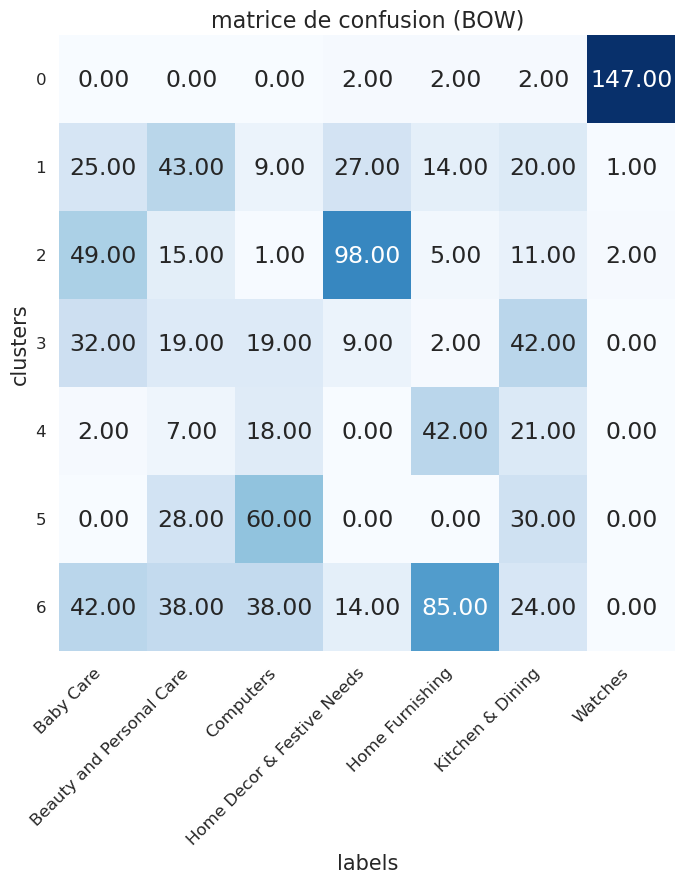

In [111]:
fctUtiles.confusion_matrix(df_tsne_tf["class"], df_tsne_tf["cluster"], 'matrice de confusion (BOW)')

##### TF-IDF

In [112]:
#Création de clusters à partir du T-SNE 
X = df_tsne_tfidf[["tsne1","tsne2"]]

cls_tfidf = KMeans(n_clusters=N_CLUSTERS, init='k-means++')
cls_tfidf.fit(X)

df_tsne_tfidf["cluster"] = cls_tfidf.labels_

sil = silhouette_score(X,cls_tfidf.labels_,metric="euclidean")
print("Le score de silhouette est",round( sil,2))

Le score de silhouette est 0.35


/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [113]:
df_tsne_tfidf.sample(10)

tsne1      tsne2                       class  cluster
809  10.794615 -44.672256             Home Furnishing        4
228 -17.783539  18.004477  Home Decor & Festive Needs        2
817 -21.720600  13.346549  Home Decor & Festive Needs        2
545   9.231322 -88.290848                     Watches        4
29   -1.456359  24.438066                     Watches        2
712 -41.107330  34.795979             Home Furnishing        6
364 -17.769678  10.447139    Beauty and Personal Care        2
762 -66.736122 -11.349795    Beauty and Personal Care        6
135 -27.099821  74.671906            Kitchen & Dining        0
433  56.147503  14.118502                   Baby Care        3

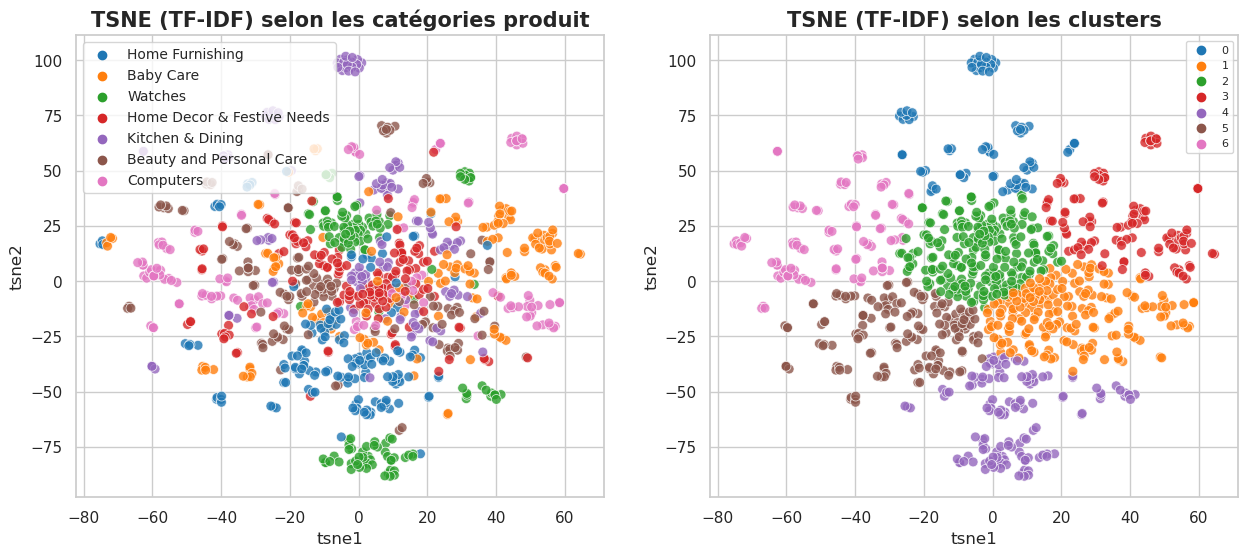

ARI :  0.127


/home/mel/OpenClassrooms/ocr_projet_6/Projet_6/fontionsUtiles_texte.py:504: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(resultats, ignore_index=True)


In [114]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_tfidf, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (TF-IDF) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_tfidf,
legend="brief")

plt.title('TSNE (TF-IDF) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_tf_idf=round( metrics.adjusted_rand_score(labels, cls_tfidf.labels_),3)
labels = df_1["label"]
print(f"ARI : ",ARI_tf_idf)
df_resultats = fctUtiles.add_model_score(df_resultats, model_name='TF-IDF ', ARI=ARI_tf_idf)


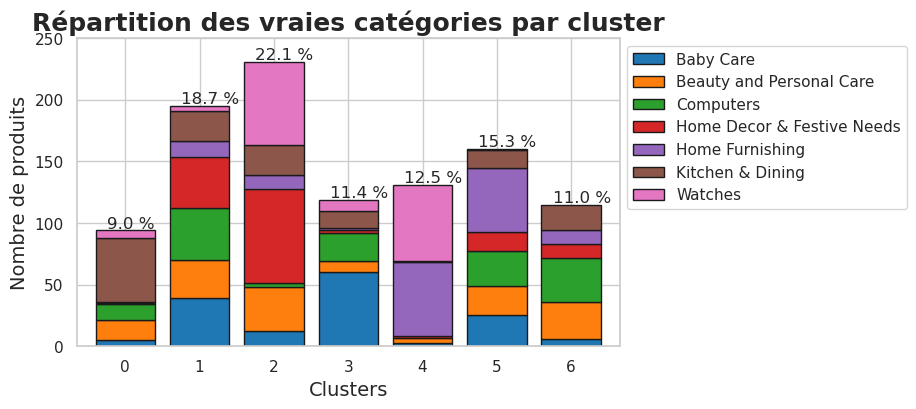

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               5.0                      16.0       13.0   
1              39.0                      31.0       42.0   
2              12.0                      36.0        3.0   
3              60.0                       9.0       23.0   
4               3.0                       4.0        0.0   
5              25.0                      24.0       28.0   
6               6.0                      30.0       36.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                1.0              1.0              52.0   
1                               42.0             13.0              24.0   
2                               77.0             11.0              24.0   
3                                2.0              2.0              14.0   
4                                1.0             60.0               1.0   
5                               16.0             52.0              14.0   
6                               11.0             11.0              21.0   

category  Watches  
label              
0             6.0  
1             4.0  
2            68.0  
3             9.0  
4            62.0  
5             1.0  
6             0.0

In [115]:
fctUtiles.plot_clust_vs_cat(df_tsne_tfidf["cluster"],
                              df_tsne_tfidf["class"],
                              df_tsne_tfidf,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,250))

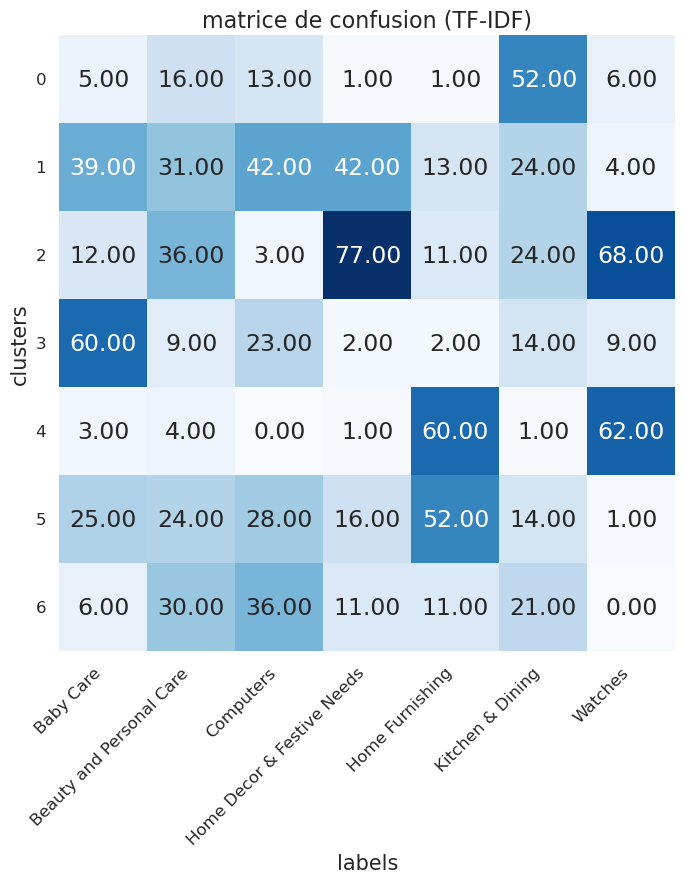

In [116]:
fctUtiles.confusion_matrix(df_tsne_tfidf["class"], df_tsne_tfidf["cluster"], 'matrice de confusion (TF-IDF)')

In [117]:
l_cat = list(set(df_1['cat_lvl_1']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df_1.iloc[i]['cat_lvl_1'])) for i in range(len(df_1))]

catégories :  ['Baby Care', 'Computers', 'Watches', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Kitchen & Dining', 'Home Furnishing']


#### Exécution du modèle

In [118]:
print("CountVectorizer : ")
print("-----------------")
ARI_tf, X_tsne_tf, labels_tf = fctUtiles.ARI_fct(l_cat, X_tf_reduce_90, y_cat_num)
print()
print("Tf-idf : ")
print("--------")
ARI_tfidf, X_tsne_tfidf, labels_tfidf = fctUtiles.ARI_fct(l_cat, X_tfidf_reduce_90, y_cat_num)

CountVectorizer : 
-----------------
ARI :  0.3752 time :  5.0

Tf-idf : 
--------
ARI :  0.3111 time :  5.0


#### Graphiques

In [119]:
##### TF

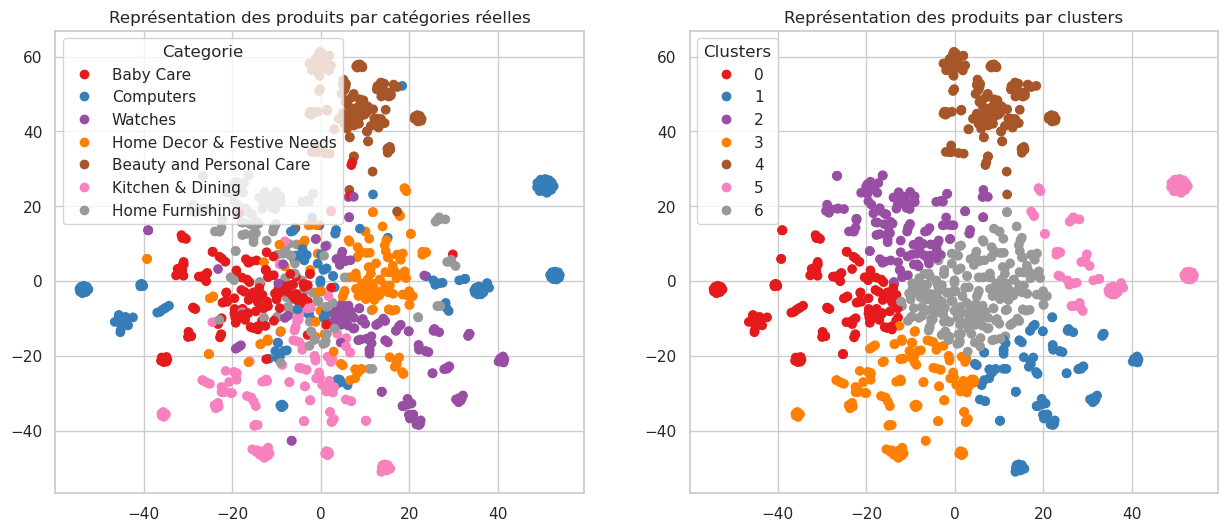

ARI :  0.3752


In [120]:
 fctUtiles.TSNE_visu_fct(X_tsne_tf, y_cat_num, labels_tf, ARI_tf, l_cat)

In [121]:
##### TF-IDF

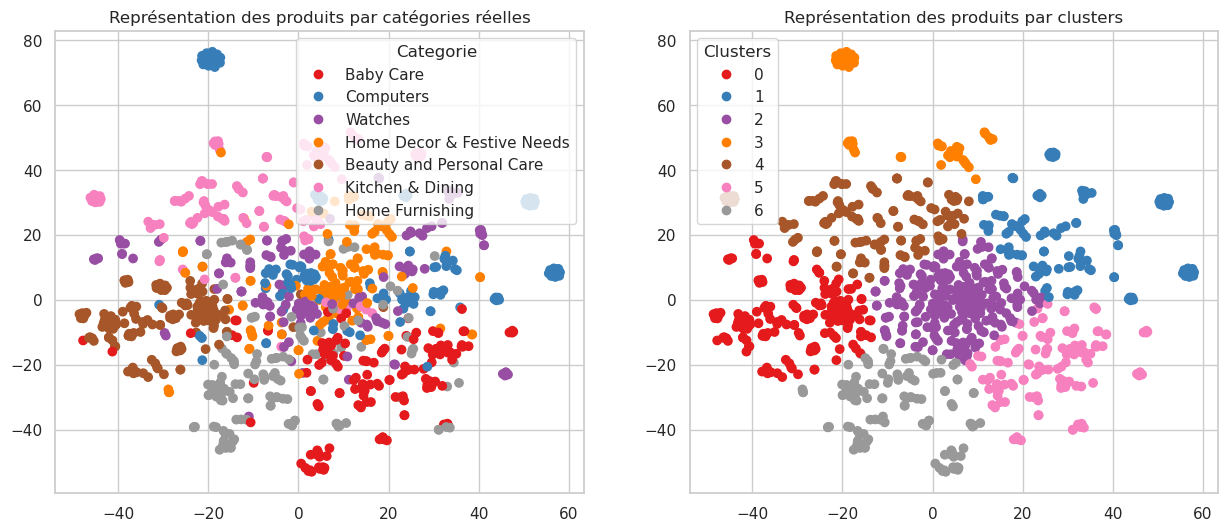

ARI :  0.3111


In [122]:
 fctUtiles.TSNE_visu_fct(X_tsne_tfidf, y_cat_num, labels_tfidf, ARI_tfidf, l_cat)

### Word2Vec

In [123]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 100 # adapt to length of sentences
sentences = df_1['clean_description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [124]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2662
Word2Vec trained


In [125]:
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2663


In [126]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (2663, 300)


def creer_vecteur_moyen_par_mot(data, text_dim, w2v_model):

    vect_moy = np.zeros((text_dim,), dtype='float32')
    num_words = 0.

    for word in data.split():
        if word in w2v_model.wv.vocab:
            vect_moy = np.add(vect_moy, w2v_model[word])
            num_words += 1.

    if num_words != 0.:
        vect_moy = np.divide(vect_moy, num_words)

    return vect_moy

In [127]:
# Création du modèle d'embedding

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          798900    
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 798,900
Trainable params: 798,900
Non-trainable params: 0
_________________________________________________________________


2023-05-21 21:20:09.168120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 21:20:09.168352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 21:20:09.168507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [128]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 875us/step


(1045, 300)

### ACP

In [129]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = decomposition.PCA(n_components=0.99)
pca_word2vec= pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", pca_word2vec.shape)

Dimensions dataset avant réduction PCA :  (1045, 300)
Dimensions dataset après réduction PCA :  (1045, 51)


### T_SNE

In [130]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_rword2vec = tsne.fit_transform(pca_word2vec)

df_tsne_word2vec = pd.DataFrame(tsne_rword2vec[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_word2vec["class"] = df_1["cat_lvl_1"]

df_tsne_word2vec.shape

(1045, 3)

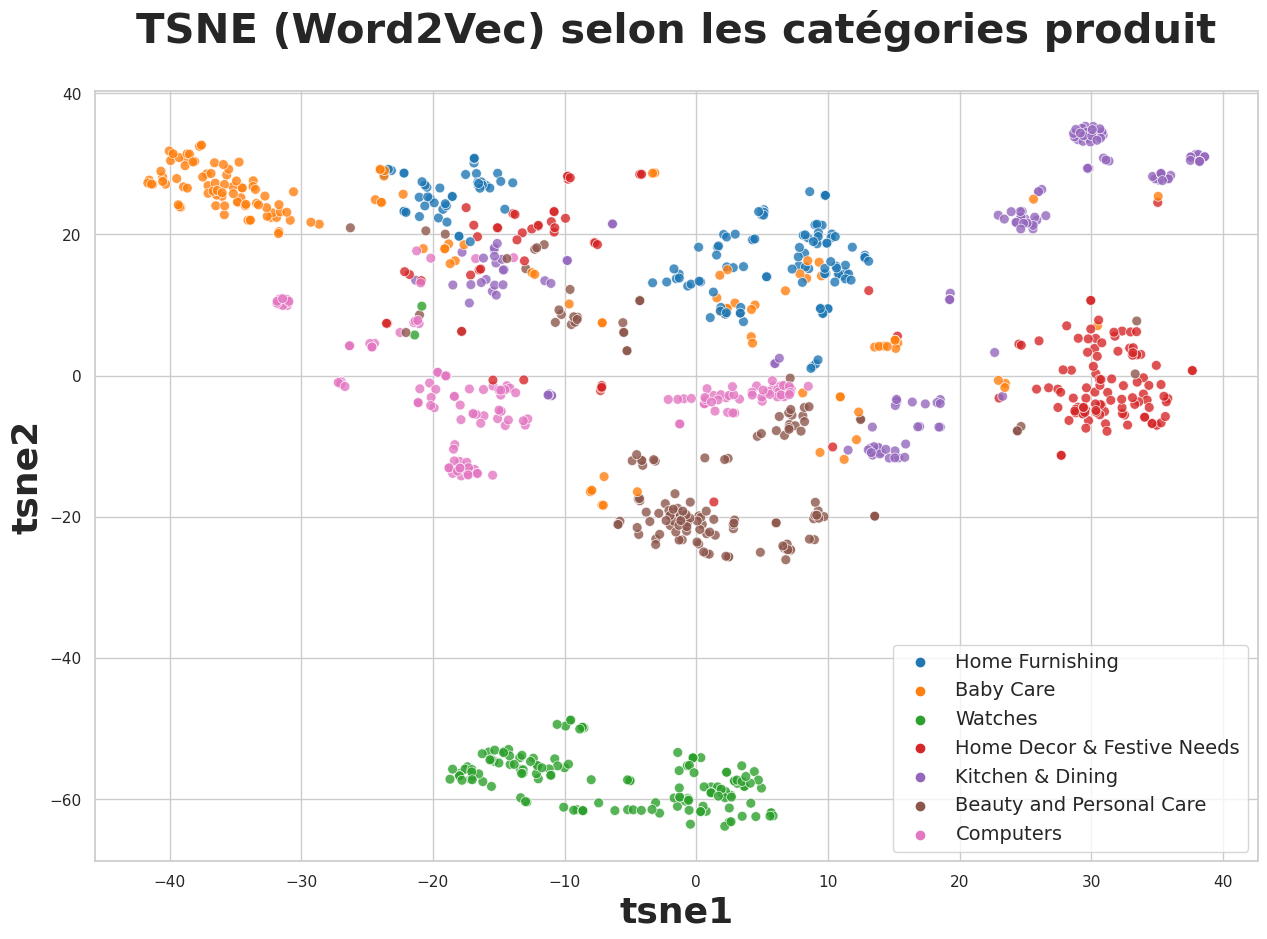

In [131]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_word2vec, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (Word2Vec) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [132]:
#Création de clusters à partir du T-SNE 
X = df_tsne_word2vec[["tsne1","tsne2"]]

cls_Word2Vec = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_Word2Vec.fit(X)

df_tsne_word2vec["cluster"] = cls_Word2Vec.labels_

sil = np.round(silhouette_score(X,cls_Word2Vec.labels_,metric="euclidean"),2)
print("====================================================")
print("Le score de silhouette est", sil)
print("====================================================")

Le score de silhouette est 0.54


/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


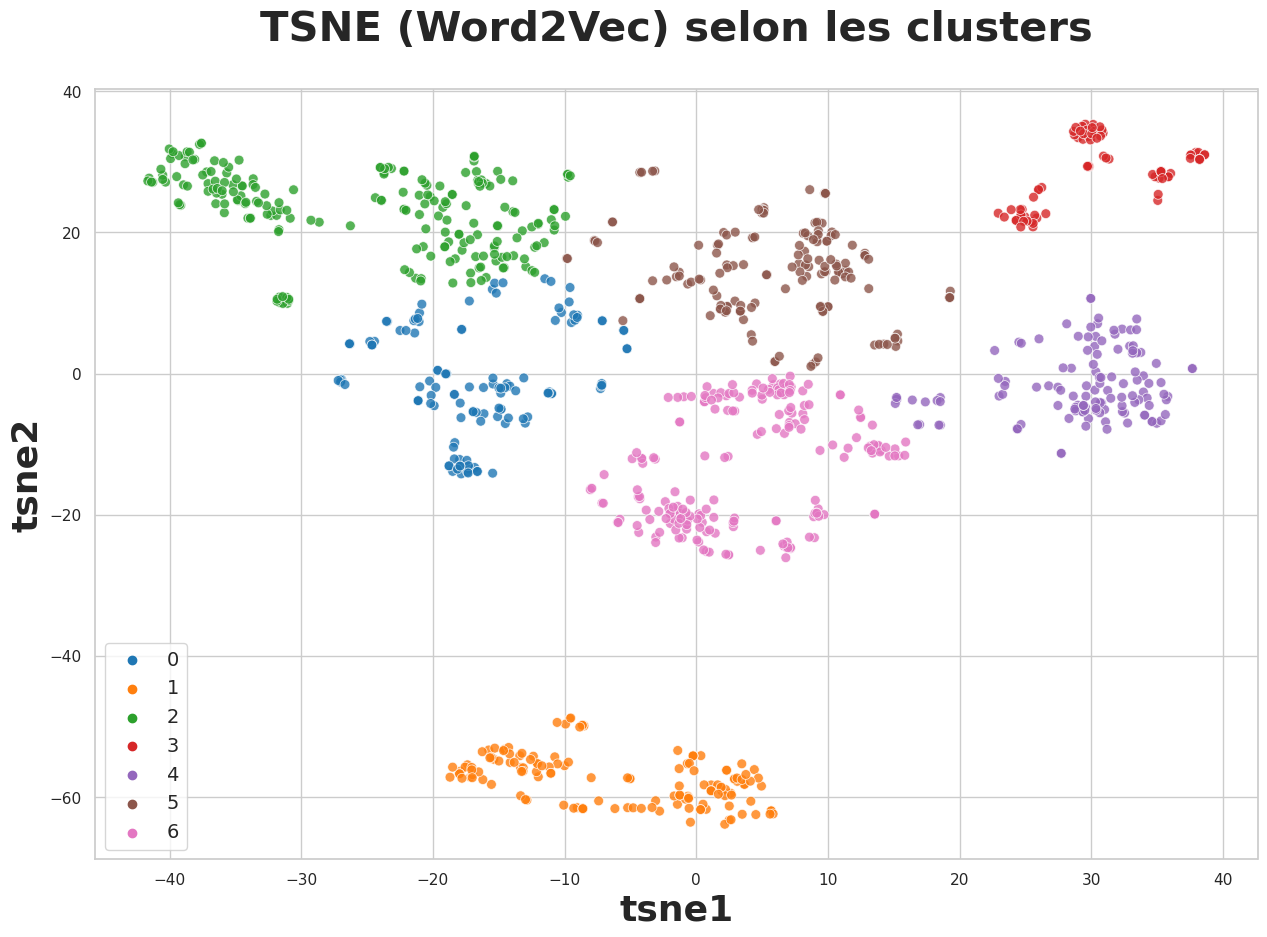

ARI :  0.446


In [133]:
#Affichage des catégories selon clusters et calcul ARI de similarité catégories images / clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_word2vec,
    legend="brief")

plt.title('TSNE (Word2Vec) selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()
ARI_Word2Vec=np.round(metrics.adjusted_rand_score(labels, cls_Word2Vec.labels_),3)
labels = df_1["label"]
print("====================================================")
print("ARI : ",ARI_Word2Vec)
print("====================================================")

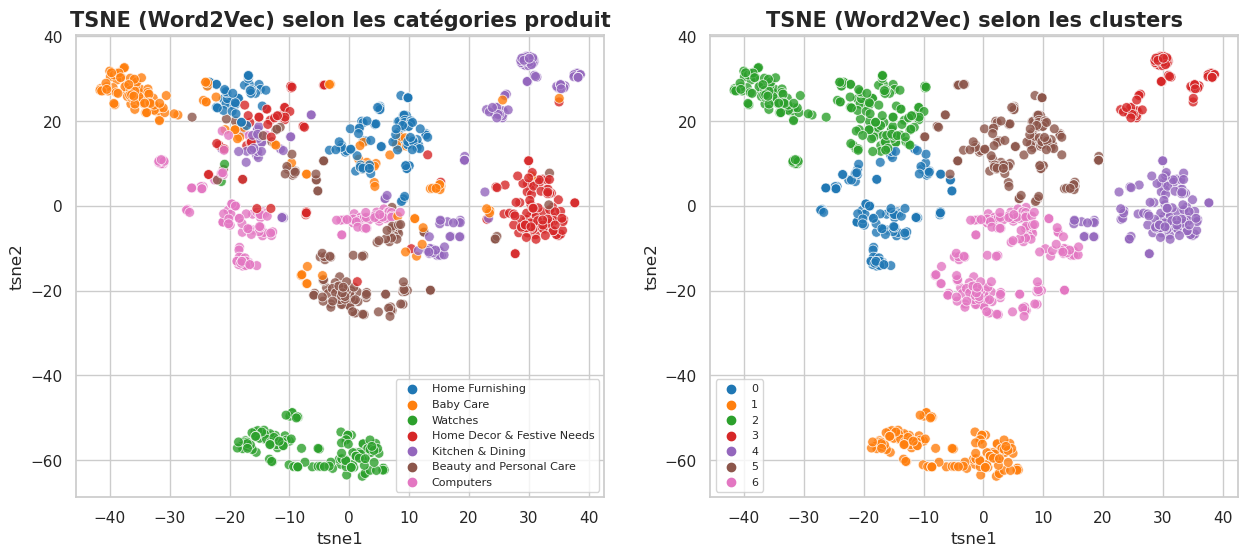

ARI :  0.446


/home/mel/OpenClassrooms/ocr_projet_6/Projet_6/fontionsUtiles_texte.py:504: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(resultats, ignore_index=True)


In [134]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_word2vec, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (Word2Vec) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 


ax = fig.add_subplot(122)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_word2vec,
    legend="brief")

plt.title('TSNE (Word2Vec) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()


ARI_Word2Vec=np.round(metrics.adjusted_rand_score(labels, cls_Word2Vec.labels_),3)

print("====================================================")
print("ARI : ",ARI_Word2Vec)
print("====================================================")
df_resultats =  fctUtiles.add_model_score(df_resultats, model_name='Word2Vec ', ARI=ARI_Word2Vec)


In [135]:
df_tsne_word2vec.groupby("cluster").count()["class"]

cluster
0    127
1    148
2    212
3     77
4    126
5    157
6    198
Name: class, dtype: int64

### Répartition des vraies catégories par cluster

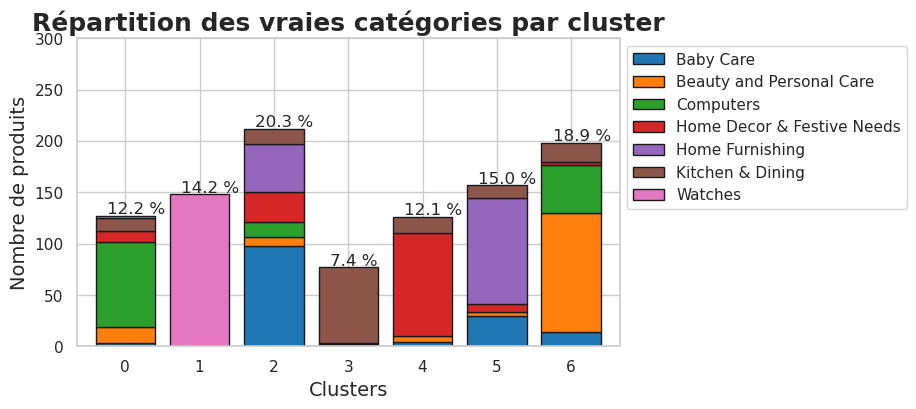

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0               3.0                      16.0       83.0   
1               0.0                       0.0        0.0   
2              98.0                       8.0       15.0   
3               2.0                       0.0        0.0   
4               4.0                       6.0        0.0   
5              29.0                       4.0        0.0   
6              14.0                     116.0       47.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                               10.0              0.0              13.0   
1                                0.0              0.0               0.0   
2                               29.0             47.0              15.0   
3                                1.0              0.0              74.0   
4                              100.0              0.0              16.0   
5                                8.0            103.0              13.0   
6                                2.0              0.0              19.0   

category  Watches  
label              
0             2.0  
1           148.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0  
6             0.0

In [136]:
fctUtiles.plot_clust_vs_cat(df_tsne_word2vec["cluster"],
                              df_tsne_word2vec["class"],
                              df_tsne_word2vec,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

### Matrice de confusion (WORD2VEC)

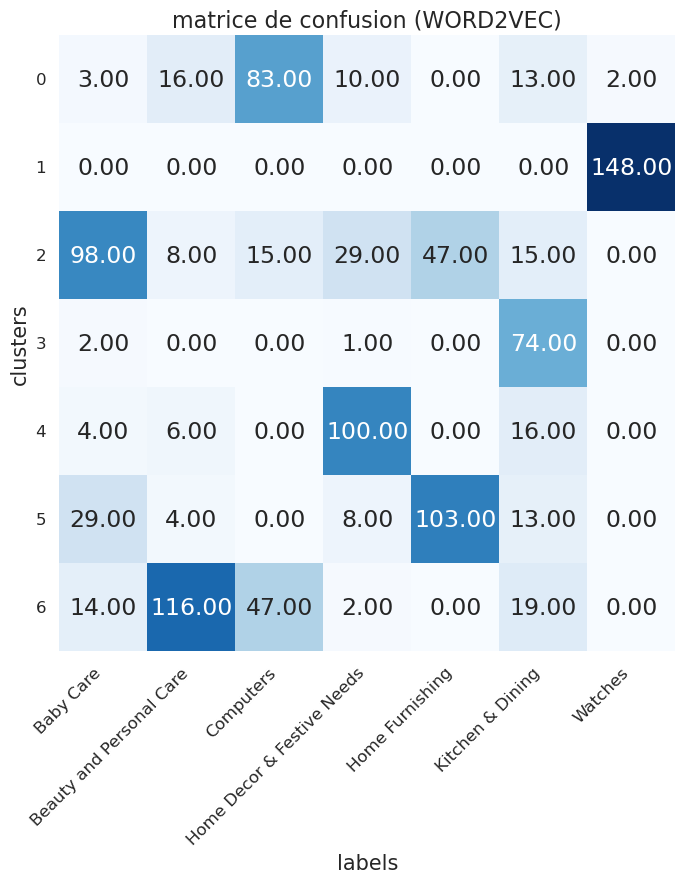

In [137]:
fctUtiles.confusion_matrix(df_tsne_word2vec['class'], df_tsne_word2vec['cluster'], 'matrice de confusion (WORD2VEC)')

In [138]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = df_1['clean_description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [139]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 2662
Word2Vec trained


In [140]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 2663


In [141]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (2663, 300)


In [142]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           798900    
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 798,900
Trainable params: 798,900
Non-trainable params: 0
_________________________________________________________________


In [143]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape



33/33 [==============================] - 0s 794us/step


(1045, 300)

In [144]:
ARI, X_tsne, labels = fctUtiles.ARI_fct(l_cat, embeddings, y_cat_num)

ARI :  0.4224 time :  4.0


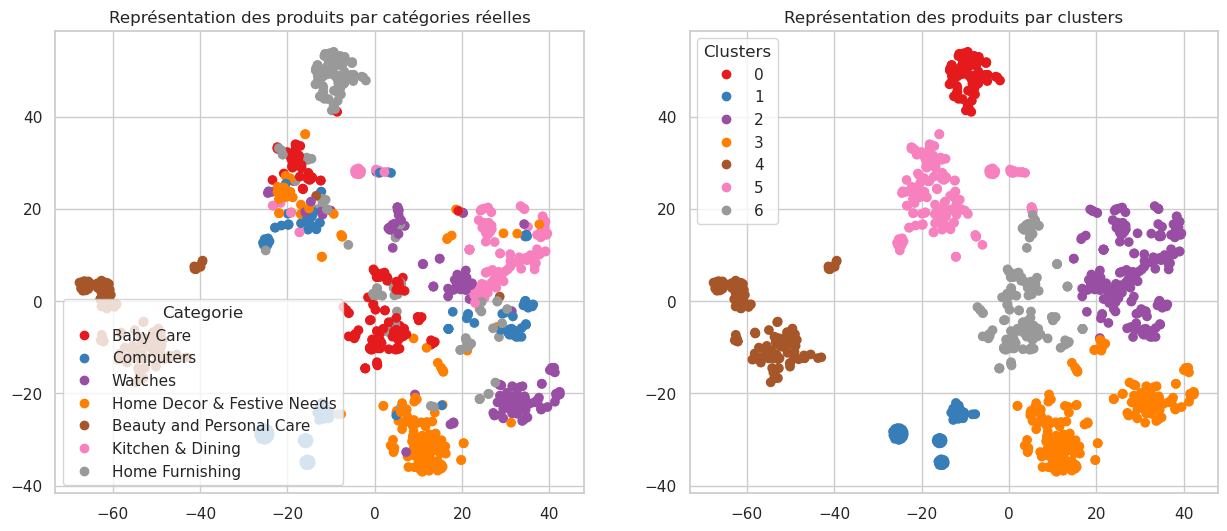

ARI :  0.4224


In [145]:
fctUtiles.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

### BERT

In [146]:
df_1['sentence_dl'] = df_1['clean_text'].apply(lambda x : fctUtiles.transform_dl_fct(x))
df_1.head(3)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   

                                                                                           product_url  \
0  http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdg...   
1           http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH   
2  http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y   

                                                 product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet Door Curtain   
1                                  Sathiyas Cotton Bath Towel   
2                         Eurospa Cotton Terry Face Towel Set   

                pid  retail_price  discounted_price  \
0  CRNEG7BKMFFYHQ8Z        1899.0             899.0   
1  BTWEGFZHGBXPHZUH         600.0             449.0   
2  BTWEG6SHXTDB2A2Y           NaN               NaN   

                                  image  is_FK_Advantage_product  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg                    False   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg                    False   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg                    False   

                                                                                           description  \
0  Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegan...   
1  Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Featur...   
2  Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa ...   

   ...       overall_rating     brand  \
0  ...  No rating available  Elegance   
1  ...  No rating available  Sathiyas   
2  ...  No rating available   Eurospa   

                                                                                product_specifications  \
0  {"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value...   
1  {"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "val...   
2  {"product_specification"=>[{"key"=>"Material", "value"=>"Cotton Terry"}, {"key"=>"Design", "valu...   

         cat_lvl_1               cat_lvl_2         cat_lvl_3 label  \
0  Home Furnishing  Curtains & Accessories          Curtains     4   
1        Baby Care        Baby Bath & Skin  Baby Bath Towels     0   
2        Baby Care        Baby Bath & Skin  Baby Bath Towels     0   

                                                                                            clean_text  \
0  [key, featur, eleg, polyest, multicolor, abstract, eyelet, door, curtain, floral, curtain, eleg,...   
1  [specif, sathiya, cotton, bath, towel, bath, towel, red, yellow, blue, bath, towel, featur, mach...   
2  [key, featur, eurospa, cotton, terri, face, towel, set, size, small, height, inch, gsm, eurospa,...   

                                                                                     clean_description  \
0  key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest mult...   
1  specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl mat...   
2  key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri f...   

                                                                                           sentence_dl  
0  key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest mult...  
1  specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl mat...  
2  key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri f...  

[3 rows x 21 col

In [147]:
df_bert_use=df_1[['cat_lvl_1','clean_description']].copy()
df_bert_use.head(5)

cat_lvl_1  \
0  Home Furnishing   
1        Baby Care   
2        Baby Care   
3  Home Furnishing   
4  Home Furnishing   

                                                                                     clean_description  
0  key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest mult...  
1  specif sathiya cotton bath towel bath towel red yellow blue bath towel featur machin washabl mat...  
2  key featur eurospa cotton terri face towel set size small height inch gsm eurospa cotton terri f...  
3  key featur santosh royal fashion cotton print king size doubl bedsheet royal bedsheet wed gift s...  
4  key featur jaipur print cotton floral king size doubl bedsheet cotton jaipur print cotton floral...

In [148]:
df_bert_use['clean_description'] = df_bert_use['clean_description'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df_bert_use['clean_description'].max())

max length dl :  296


In [149]:
df_1['clean_description'].min()

'aapno rajasthan marvel marbl gold emboss roli tika chopra showpiec onlin aapno rajasthan marvel marbl gold emboss roli tika chopra showpiec'

### BERT HuggingFace
#### Model 'bert-base-uncased'

In [150]:
#df_1['clean_description'].to_list()

In [151]:
max_length = 64
batch_size = 5
model_type = 'bert-base-uncased'
model = transformers.TFAutoModel.from_pretrained(model_type)
sentences = df_1['clean_description'].to_list()

In [152]:
from transformers import AutoTokenizer
# Création des features
# downloads bert features
features_bert, last_hidden_states_tot = fctUtiles.feature_BERT_fct(model, model_type, sentences,max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 18ms/step
temps traitement :  25.0


In [153]:
features_bert.shape

(1045, 768)

In [154]:
last_hidden_states_tot.shape

(5, 64, 768)

### Réduction des dimensions

#### PCA

In [155]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.99)
pca_bert= pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", pca_bert.shape)

Dimensions dataset avant réduction PCA :  (1045, 768)
Dimensions dataset après réduction PCA :  (1045, 339)


#### T-NSE

In [156]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_bert = tsne.fit_transform(pca_bert)

df_tsne_bert = pd.DataFrame(tsne_bert[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert["class"] = df_1["cat_lvl_1"]
print(df_tsne_bert.shape)

(1045, 3)


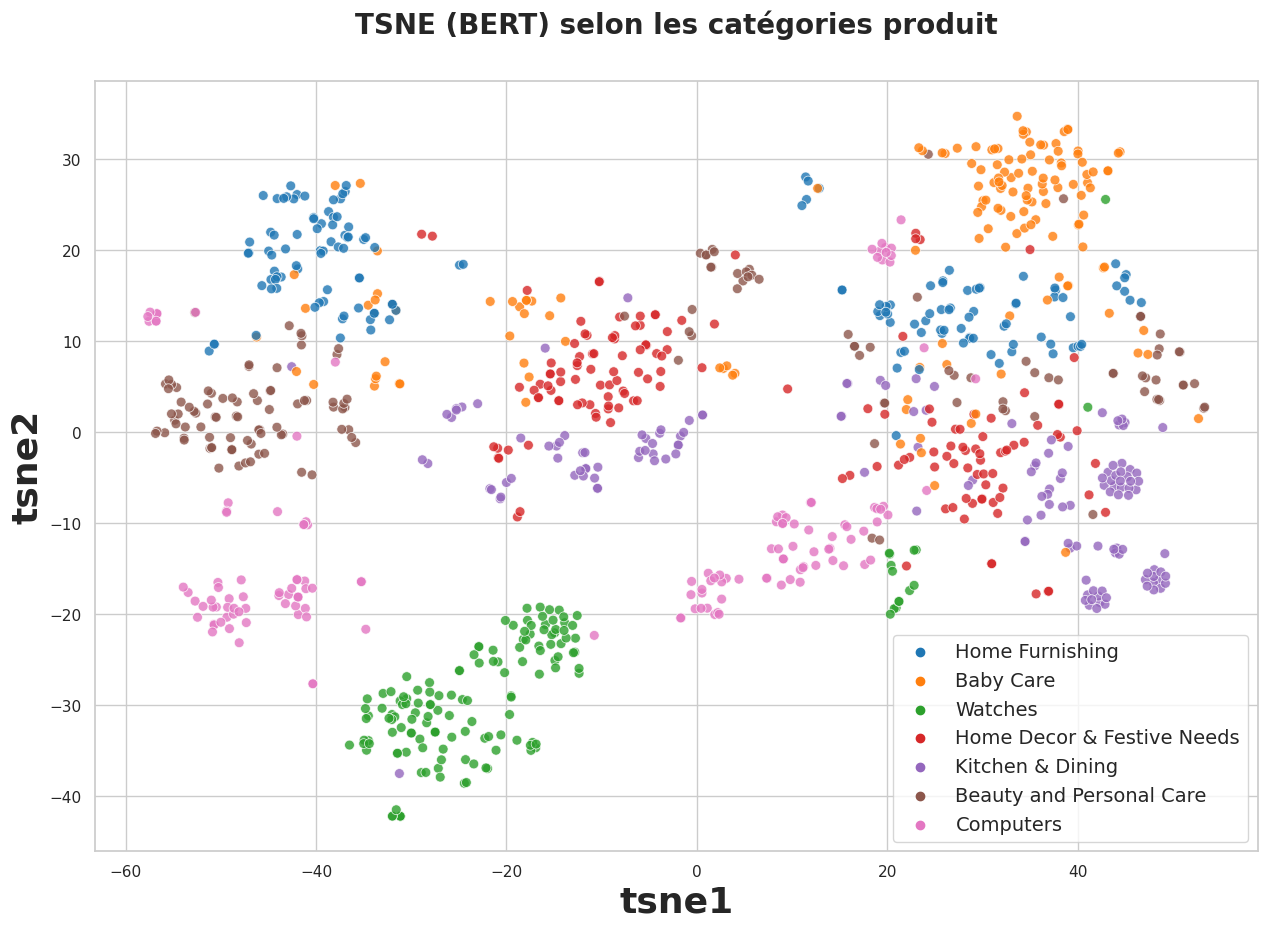

In [157]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT) selon les catégories produit', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [158]:
#Création de clusters à partir du T-SNE 
X = df_tsne_bert[["tsne1","tsne2"]]

cls_bert = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_bert.fit(X)

df_tsne_bert["cluster"] = cls_bert.labels_

sil = np.round(silhouette_score(X,cls_bert.labels_,metric="euclidean"),2)
print("====================================================")
print("Le score de silhouette est", sil)
print("====================================================")

Le score de silhouette est 0.47


/home/mel/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


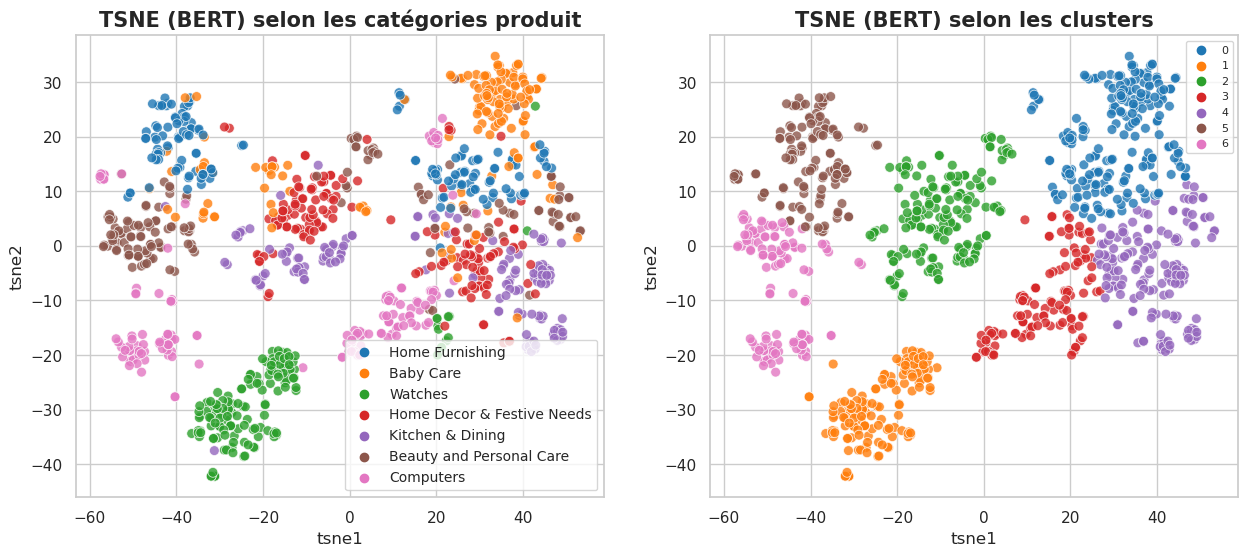

ARI :  0.334


/home/mel/OpenClassrooms/ocr_projet_6/Projet_6/fontionsUtiles_texte.py:504: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(resultats, ignore_index=True)


In [159]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
data=df_tsne_bert,legend="brief")

plt.title('TSNE (BERT) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()
ARI_bert1 =round( metrics.adjusted_rand_score(labels, cls_bert.labels_),3)
labels = df_1["label"]
print("====================================================")
print(f"ARI : ",ARI_bert1 )
print("====================================================")
df_resultats = fctUtiles.add_model_score(df_resultats, model_name='BERT (bert-base-uncased) ', ARI=ARI_bert1 )


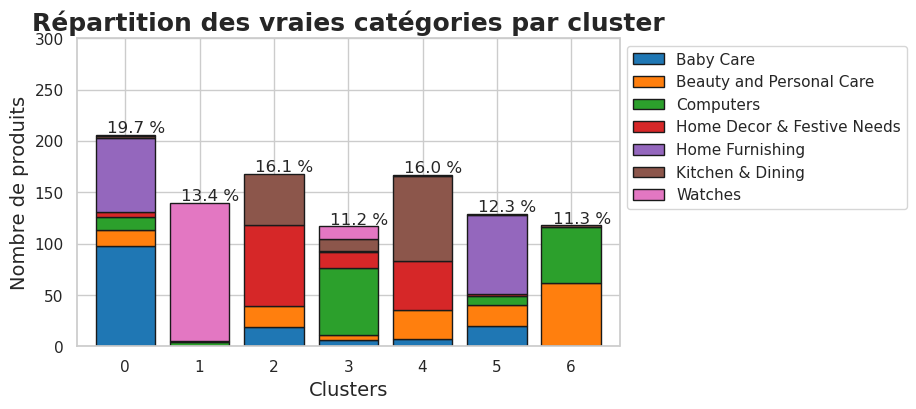

category  Baby Care  Beauty and Personal Care  Computers  \
label                                                      
0              98.0                      15.0       13.0   
1               0.0                       0.0        4.0   
2              19.0                      20.0        0.0   
3               6.0                       5.0       65.0   
4               7.0                      28.0        0.0   
5              20.0                      20.0        9.0   
6               0.0                      62.0       54.0   

category  Home Decor & Festive Needs  Home Furnishing  Kitchen & Dining  \
label                                                                     
0                                5.0             72.0               2.0   
1                                0.0              0.0               1.0   
2                               79.0              0.0              50.0   
3                               16.0              1.0              11.0   
4                               48.0              0.0              83.0   
5                                2.0             77.0               1.0   
6                                0.0              0.0               2.0   

category  Watches  
label              
0             1.0  
1           135.0  
2             0.0  
3            13.0  
4             1.0  
5             0.0  
6             0.0

In [160]:
fctUtiles.plot_clust_vs_cat(df_tsne_bert["cluster"],
                              df_tsne_bert["class"],
                              df_tsne_bert,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

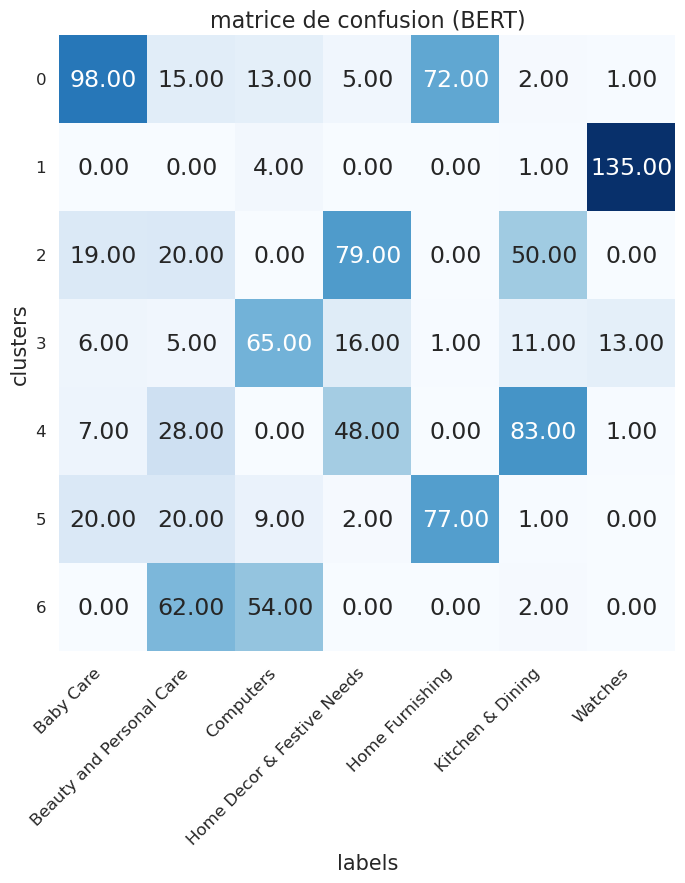

In [161]:
fctUtiles.confusion_matrix(df_tsne_bert["class"], df_tsne_bert["cluster"], 'matrice de confusion (BERT)')

### BERT hub Tensorflow

In [162]:
import tensorflow_hub
import tensorflow_hub as hub

In [163]:
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
# downloads 500Mb de model
small_model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
with tf.device('/gpu:0'):
    bert_layer = tensorflow_hub.KerasLayer(model_url, trainable=True)

In [164]:
sentences = df_1['clean_description'].to_list()
max_length = 64
batch_size = 5
model_type = 'bert-base-uncased'
model = bert_layer

In [165]:
from transformers import AutoTokenizer

In [ ]:
features_bert_hub_Tensorflow, last_hidden_states_tot = fctUtiles.feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

In [ ]:
### REDUCTION DE DIMENSION

In [ ]:
#### ACP

In [ ]:
print("Dimensions dataset avant réduction PCA : ", features_bert_hub_Tensorflow.shape)
pca = decomposition.PCA(n_components=0.99)
pca_bert_hub_Tensorflow = pca.fit_transform(features_bert_hub_Tensorflow)
print("Dimensions dataset après réduction PCA : ", pca_bert_hub_Tensorflow.shape)

In [ ]:
#### T-NSE

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_bert_hub_Tensorflow = tsne.fit_transform(pca_bert_hub_Tensorflow)

df_tsne_bert_hub_Tensorflow = pd.DataFrame(tsne_bert_hub_Tensorflow[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_bert_hub_Tensorflow["class"] = df_1["cat_lvl_1"]
print(df_tsne_bert_hub_Tensorflow.shape)

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_bert_hub_Tensorflow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT_hub_Tensorflow) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [ ]:
#Création de clusters à partir du T-SNE 
N_CLUSTERS = 7
X = df_tsne_bert_hub_Tensorflow[["tsne1","tsne2"]]

cls_bert3 = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_bert3.fit(X)

df_tsne_bert_hub_Tensorflow["cluster"] = cls_bert3.labels_

sil = np.round(silhouette_score(X,cls_bert3.labels_,metric="euclidean"),2)
print("====================================================")
print("Le score de silhouette est", sil)
print("====================================================")

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_bert_hub_Tensorflow, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (BERT_hub_Tensorflow) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_bert_hub_Tensorflow,legend="brief")

plt.title('TSNE (BERT_hub_Tensorflow) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df_1["label"]
ARI_bert3=np.round(metrics.adjusted_rand_score(labels, cls_bert3.labels_),3)

print("====================================================")
print(f"ARI : ",ARI_bert3)
print("====================================================")
df_resultats = fctUtiles.add_model_score(df_resultats, model_name='BERT(hub Tensorflow) ', ARI=ARI_bert3)

In [ ]:
df_tsne_bert_hub_Tensorflow.groupby("cluster").count()["class"]

In [ ]:
## Répartition des vraies catégories par cluster(Qualité de la catégorisation)

In [ ]:
fctUtiles.plot_clust_vs_cat(df_tsne_bert_hub_Tensorflow["cluster"],
                              df_tsne_bert_hub_Tensorflow["class"],
                              df_tsne_bert_hub_Tensorflow,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

In [ ]:
fctUtiles.confusion_matrix( df_tsne_bert_hub_Tensorflow["class"],  df_tsne_bert_hub_Tensorflow["cluster"],
                 'matrice de confusion ( BERT_hub_Tensorflow)')

In [ ]:
## USE - Universal Sentence Encoder

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
USE_model_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# 1Gb model
with tf.device('/gpu:0'):
    embed = hub.load(USE_model_url)

In [ ]:
batch_size = 5
sentences = df_1['clean_description'].to_list()

In [ ]:
df_USE = fctUtiles.feature_USE_fct(embed, sentences, batch_size)

### Réduction des dimensions

#### PCA

In [ ]:
print("Dimensions dataset avant réduction PCA : ", df_USE.shape)
pca = decomposition.PCA(n_components=0.99)
pca_USE = pca.fit_transform(df_USE)
print("Dimensions dataset après réduction PCA : ", pca_USE.shape)

#### T-SNE

In [ ]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
tsne_bert_hub_Tensorflow = tsne.fit_transform(pca_USE)

df_tsne_USE = pd.DataFrame(tsne_bert_hub_Tensorflow [:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_USE["class"] = df_1["cat_lvl_1"]
df_tsne_USE.shape

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_USE, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (USE) selon les catégories produit', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

In [ ]:
#Création de clusters à partir du T-SNE 
N_CLUSTERS = 7
X = df_tsne_USE[["tsne1","tsne2"]]

cls_use = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
cls_use.fit(X)

df_tsne_USE["cluster"] = cls_use.labels_

sil = np.round(silhouette_score(X,cls_use.labels_,metric="euclidean"),2)
print("====================================================")
print("Le score de silhouette est", sil)
print("====================================================")

In [ ]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
    
sns.scatterplot(
x="tsne1", y="tsne2", hue="class", data=df_tsne_USE, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE (USE) selon les catégories produit', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1' )
plt.ylabel('tsne2')
plt.legend(prop={'size': 10}) 


ax = fig.add_subplot(122)
sns.scatterplot(
x="tsne1", y="tsne2",
hue="cluster",
palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8, data=df_tsne_USE,legend="brief")

plt.title('TSNE (USE) selon les clusters', fontsize = 15, fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df_1["label"]
ARI_use=np.round(metrics.adjusted_rand_score(labels, cls_use.labels_),3)

print("====================================================")
print(f"ARI : ",ARI_use)
print("====================================================")
df_resultats = fctUtiles.add_model_score(df_resultats, model_name='USE ', ARI=ARI_use)


In [ ]:
df_tsne_USE.groupby("cluster").count()["class"]

In [ ]:
fctUtiles.plot_clust_vs_cat(df_tsne_USE["cluster"],
                              df_tsne_USE["class"],
                              df_tsne_USE,   
                              palette='tab10',
                              figsize=(7,4),
                              bboxtoanchor=(1,1), ylim=(0,300))

In [ ]:
fctUtiles.confusion_matrix( df_tsne_USE["class"],  df_tsne_USE["cluster"],
                 'matrice de confusion (USE)')

In [ ]:
df_resultats

### Fin